# ▂▂▂▂▂▂▂▂▂▂▂▂

# Modded-NanoGPT

In [2]:
!pip install boto3

  Using cached boto3-1.41.2-py3-none-any.whl.metadata (6.8 kB)
  Using cached botocore-1.41.2-py3-none-any.whl.metadata (5.9 kB)
  Using cached jmespath-1.0.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached s3transfer-0.15.0-py3-none-any.whl.metadata (1.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 113.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 8.8 MB/s eta 0:00:00


# ▂▂▂▂▂▂▂▂▂▂▂▂

# Setup

In [3]:
import os
import sys

import copy
import glob
import math
import threading
import time
import uuid
from dataclasses import dataclass
from collections import defaultdict
from itertools import accumulate
from pathlib import Path

os.environ["PYTORCH_ALLOC_CONF"] = "expandable_segments:True"
import torch

torch.empty(
    1, device="cuda", requires_grad=True
).backward()  # prevents a bug on some systems
import torch._dynamo as dynamo
import torch.distributed as dist
import torch.nn.functional as F

# torch._inductor.config.coordinate_descent_tuning = True # we have banned this flag for new records because it causes compilation to take 30min
import triton
import triton.language as tl

from torch import Tensor, nn

dynamo.config.recompile_limit = 64

In [4]:
import time

# Measure the notebook's end-to-end runtime.
full_notebook_t0 = time.time()

In [5]:
# Set a flag we can use to determine if we are running within a Colab instance.
is_colab = "google.colab" in str(get_ipython())

**Distributed Training**

Manually set the environment variables used for distributed training to configure it for a single GPU.

Normally these are set by invoking the script from the command line with `torchrun`, but since we're in a notebook...

In [6]:
import os

os.environ['WORLD_SIZE'] = '1' # Single (node?)
os.environ['RANK'] = '0'
os.environ['LOCAL_RANK'] = '0' # This is the one gpu

# Part of the workaround to running with `dist` on a single GPU.
os.environ['MASTER_ADDR']  = '127.0.0.1'
os.environ['MASTER_PORT']  = '29500'

**Memory During Validation**

I hit OOM during validation on the A100, but this was easily resolved by increasing the number of accumulation steps to use during validation. Default is 8, I bumped it to 32 to be safe. (To be clear--training still uses 8).

In [7]:
if is_colab:
    val_accum_steps = 32
else:
    val_accum_steps = 8 # Same as training

## Flash Attention on Colab

FlashAttention does not come pre-installed on Colab instances, and is very time consuming to install manually because it has to be built from source.

The below GitHub repo, however, provides pre-built wheels which make setup easy.

https://github.com/mjun0812/flash-attention-prebuild-wheels/releases

The key is just to identify the correct wheel to use from the giant list.

We need the wheel specific to our version of python, pytorch, and CUDA. So first we'll print those out:

In [1]:
!pip install torch==2.8.0 --index-url https://download.pytorch.org/whl/cu126

Looking in indexes: https://download.pytorch.org/whl/cu126
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.8/821.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.4/322.4 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 MB 17.1 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.5.0
    Uninstalling triton-3.5.0:
      Successfully uninstalled triton-3.5.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.27.5
    Uninstalling nvidia-nccl-cu12-2.27.5:
      Successfully uninstalled nvidia-nccl-cu12-2.27.5
  Attempting uninstall: torch
    Found existing installation: torch 2.9.0+cu126
    Uninstalling torch-2.9.0+cu126:
      Successfully uninstalled torch-2.9.0+cu126
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2

In [8]:
import torch
import sys

print("Python:", sys.version)
print("PyTorch:", torch.__version__)
print("CUDA:", torch.version.cuda)
print("")
print("GPU:", torch.cuda.get_device_name(0))

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch: 2.8.0+cu126
CUDA: 12.6

GPU: NVIDIA A100-SXM4-80GB


It's difficult to find the correct wheel because they are all hidden underneath different releases, and searching the page doesn't work unless the releases are expanded.

With some hunting, I was able to find the correct version for Colab's current configuration:

In [9]:
fa_installed

NameError: name 'fa_installed' is not defined

In [10]:
import importlib.util
import os

# Check if it's installed already
fa_installed = importlib.util.find_spec("flash_attn") is not None

# This wheel is specific to Colab.
if is_colab or not fa_installed:
    fa_install_t0 = time.time()

    # Define the wheel details
    WHEEL_URL = "https://github.com/mjun0812/flash-attention-prebuild-wheels/releases/download/v0.4.11/flash_attn-2.8.3+cu126torch2.8-cp312-cp312-linux_x86_64.whl"
    WHEEL_NAME = "flash_attn-2.8.3+cu126torch2.8-cp312-cp312-linux_x86_64.whl"

    # Download and install the wheel
    !wget {WHEEL_URL}
    !pip install {WHEEL_NAME}

    # Clean up the downloaded file
    os.remove(WHEEL_NAME)

    fa_install_time = time.time() - fa_install_t0
    print(f"FlashAttention installed in {fa_install_time:.2f} seconds.")

    fa_installed = True

--2025-11-23 19:51:41--  https://github.com/mjun0812/flash-attention-prebuild-wheels/releases/download/v0.4.11/flash_attn-2.8.3+cu126torch2.8-cp312-cp312-linux_x86_64.whl
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/878958395/9d318eca-33f7-4c0d-9b3f-6e90e52421f8?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-11-23T20%3A41%3A54Z&rscd=attachment%3B+filename%3Dflash_attn-2.8.3%2Bcu126torch2.8-cp312-cp312-linux_x86_64.whl&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-11-23T19%3A40%3A57Z&ske=2025-11-23T20%3A41%3A54Z&sks=b&skv=2018-11-09&sig=Sbx8MkSJTNgUP23G0B%2Br0vy%2FX0n9U7SHiUuBnmQ6Ja4%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbn

In [11]:
import importlib.metadata

if fa_installed:
    print("Flash Attention version:", importlib.metadata.version("flash-attn"))

Flash Attention version: 2.8.3


**FlashAttention3, FP8**

The speed run code uses FlashAttention3 using a kernel created by one of the users, @varunneal, but it's compiled for the specific environment used for the official records.

As noted earlier, on the GH200, I skip this and fallback to the pre-installed FA2.

For the A100, we'll also use FlashAttention2, installed above, and disable FP8 (A100 doesn't support it).

In [12]:
import os

# Get the architecture version
cc_major, cc_minor = torch.cuda.get_device_capability()

use_fa3 = False

# True on H100, false on A100
if cc_major >= 9 and use_fa3:
    from kernels import get_kernel

    print("Using FlashAttention3")
    flash_attn_interface = get_kernel('varunneal/flash-attention-3').flash_attn_interface

    print("Running with 8-bit precision for LM-head")
    os.environ["DISABLE_FP8"] = "False"

# Lambda GH200 defaults:
#      Python: 3.10.12 (main, May 27 2025, 17:12:29) [GCC 11.4.0]
#     PyTorch: 2.7.0
#        CUDA: 12.8
#   FlashAttn: 2.7.4.post1
elif cc_major >= 9:

    print("Using FlashAttention2")
    from flash_attn import flash_attn_interface

    print("Running with 8-bit precision for LM-head")
    os.environ["DISABLE_FP8"] = "False"

# Colab A100:
#
elif cc_major < 9:
    print("Using FlashAttention2")
    from flash_attn import flash_attn_interface

    print("Running with BF16 for LM-head")
    os.environ["DISABLE_FP8"] = "True"

Using FlashAttention2
Running with BF16 for LM-head


## Retrieve Dataset

This is just the contents of the [cached_fineweb10B.py](https://github.com/KellerJordan/modded-nanogpt/blob/master/data/cached_fineweb10B.py) script.


In [13]:
retrieve_data_t0 = time.time()


To download from the hub, you'll need to provide your huggingface token. The easiest way to provide this in Colab is to use the secrets panel (the key symbol on the left) and store it with the name `HF_TOKEN`.

In [14]:
if importlib.util.find_spec("huggingface_hub") is None:
    !pip install huggingface_hub

In [15]:
import os
import sys
from huggingface_hub import hf_hub_download

num_chunks = 9 # downloads only the first 900M training tokens to save time

# Download the GPT-2 tokens of Fineweb10B from huggingface. This
# saves about an hour of startup time compared to regenerating them.
def get(fname):

    local_dir = 'data/fineweb10B'

    if not os.path.exists(os.path.join(local_dir, fname)):

        hf_hub_download(
            repo_id="kjj0/fineweb10B-gpt2",
            filename=fname,
            repo_type="dataset",
            local_dir=local_dir
        )

os.makedirs("data/fineweb10b", exist_ok=True)

get("fineweb_val_%06d.bin" % 0)

for i in range(1, num_chunks+1):
    get("fineweb_train_%06d.bin" % i)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


fineweb_val_000000.bin:   0%|          | 0.00/200M [00:00<?, ?B/s]

fineweb_train_000001.bin:   0%|          | 0.00/200M [00:00<?, ?B/s]

fineweb_train_000002.bin:   0%|          | 0.00/200M [00:00<?, ?B/s]

fineweb_train_000003.bin:   0%|          | 0.00/200M [00:00<?, ?B/s]

fineweb_train_000004.bin:   0%|          | 0.00/200M [00:00<?, ?B/s]

fineweb_train_000005.bin:   0%|          | 0.00/200M [00:00<?, ?B/s]

fineweb_train_000006.bin:   0%|          | 0.00/200M [00:00<?, ?B/s]

fineweb_train_000007.bin:   0%|          | 0.00/200M [00:00<?, ?B/s]

fineweb_train_000008.bin:   0%|          | 0.00/200M [00:00<?, ?B/s]

fineweb_train_000009.bin:   0%|          | 0.00/200M [00:00<?, ?B/s]

In [16]:
retrieve_data_time = time.time() - retrieve_data_t0
minutes = int(retrieve_data_time // 60)
seconds = int(retrieve_data_time % 60)
print(f"Time for retrieving dataset: {minutes} minutes and {seconds} seconds.")

Time for retrieving dataset: 0 minutes and 20 seconds.


##### Helpers

In [17]:
from typing import Iterable, Tuple
import torch.nn as nn

def format_size(num: int) -> str:
    """Format base-2 quantities with the appropriate suffix."""

    suffixes = [" ", "K", "M", "B"] # and "T"

    base = 1024

    # Find the largest appropriate suffix.
    for suffix in suffixes:
        if abs(num) < base:
            if num % 1 != 0:
                return f"{num:.2f}{suffix}"
            else:
                return f"{num:.0f}{suffix}"
        num /= base
    if num % 1 != 0:
        return f"{num:.2f}T"
    return f"{num:.0f}T"


In [18]:
def summarize_parameters(model: nn.Module, display_bias: bool = True) -> int:
    """Print a table of parameter names, shapes and counts."""

    # Retrieve the list of parameters with their names.
    params: Iterable[Tuple[str, nn.Parameter]] = list(model.named_parameters())

    print("The model has {:} different named parameters.\n".format(len(params)))

    # Print out the parameters and their shapes in table form.
    print(
        "Parameter Name                                    Dimensions       Total Values    Trainable    Type\n"
    )

    for p_name, p in params:
        p_size = list(p.size())
        for i in range(len(p_size) - 1, -1, -1):
            if p_size[i] == 1:
                del p_size[i]
        if len(p_size) == 1:
            if not display_bias:
                continue
            p_dims = "{:>10,} x {:<10}".format(p.size()[0], "-")
        elif len(p_size) == 2:
            p_dims = "{:>10,} x {:<10,}".format(p.size()[0], p.size()[1])
        elif len(p_size) == 3:
            p_dims = "{:>10,} x {:,} x {:<10}".format(p.size()[0], p.size()[1], p.size()[2])
        elif len(p_size) == 4:
            p_dims = "{:>10,} x {:,} x {:,} x {:<10}".format(
                p.size()[0], p.size()[1], p.size()[2], p.size()[3]
            )
        else:
            print("Unexpected: ", p.size(), p_name)
            break
        print(
            "{:<45} {:}    {:>6}    {:}         {:}".format(
                p_name, p_dims, format_size(p.numel()), p.requires_grad, p.dtype
            )
        )

    # Tally up the total number of values.
    total_params = 0
    for _, p in params:
        total_params += p.numel()

    print(f"\nTotal elements: {format_size(total_params)} ({total_params:,})\n")

    print("K = 2^10 = 1,024")
    print("M = 2^20 = 1,048,576")
    print("B = 2^30 = 1,073,741,824")

    return total_params

# ▂▂▂▂▂▂▂▂▂▂▂▂

# Kernels and Optimizers

In [19]:
import os
import sys

with open(sys.argv[0]) as f:
    code = f.read()  # read the code of this file ASAP, for logging
import copy
import glob
import math
import threading
import time
import uuid
from dataclasses import dataclass
from itertools import accumulate
from pathlib import Path

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import torch

torch.empty(
    1, device="cuda", requires_grad=True
).backward()  # prevents a bug on some systems
import torch._dynamo as dynamo
import torch.distributed as dist
import torch.nn.functional as F

# torch._inductor.config.coordinate_descent_tuning = True # we have banned this flag for new records because it causes compilation to take 30min
import triton
import triton.language as tl
from torch import Tensor, nn

dynamo.config.recompile_limit = 64


## Custom Operators

In [20]:
# -----------------------------------------------------------------------------
# Custom operators: FP8 matmul by @YouJiacheng

**`mm_op`**

In [21]:
@torch.library.custom_op("nanogpt::mm", mutates_args=())
def mm_op(x: Tensor, w: Tensor, x_s: float, w_s: float, grad_s: float) -> tuple[Tensor, Tensor, Tensor]:
    @torch.compile
    def impl(x: Tensor, w: Tensor):
        assert x.is_contiguous() and w.is_contiguous()
        x_f8 = x.div(x_s).to(torch.float8_e4m3fn)
        w_f8 = w.div(w_s).to(torch.float8_e4m3fn)
        out = torch._scaled_mm(
            x_f8,
            w_f8.T,
            out_dtype=torch.bfloat16,
            scale_a=x.new_tensor(x_s, dtype=torch.float32),
            scale_b=x.new_tensor(w_s, dtype=torch.float32),
            use_fast_accum=True,
        )
        return out, x_f8, w_f8

    return impl(x, w)

**`_`**

In [22]:
@mm_op.register_fake
def _(x: Tensor, w: Tensor, *_):
    assert x.ndim == w.ndim == 2
    assert x.shape[1] == w.shape[1]
    assert x.device == w.device
    assert x.is_contiguous() and w.is_contiguous()
    return x @ w.T, x.to(torch.float8_e4m3fn), w.to(torch.float8_e4m3fn)

**`mm_backward_op`**

In [23]:
@torch.library.custom_op("nanogpt::mm_backward", mutates_args=())
def mm_backward_op(g: Tensor, x_f8: Tensor, w_f8: Tensor, x_s: float, w_s: float, grad_s: float) -> tuple[Tensor, Tensor]:
    @torch.compile
    def impl(grad: Tensor, x_f8: Tensor, w_f8: Tensor):
        assert grad.is_contiguous()
        x_inv_s = grad.new_tensor(x_s, dtype=torch.float32)
        w_inv_s = grad.new_tensor(w_s, dtype=torch.float32)
        grad_inv_s = grad.new_tensor(grad_s, dtype=torch.float32)
        grad_f8 = grad.div(grad_s).to(torch.float8_e5m2)
        grad_x = torch._scaled_mm(
            grad_f8,
            w_f8.T.contiguous().T,
            out_dtype=torch.bfloat16,
            scale_a=grad_inv_s,
            scale_b=w_inv_s,
            use_fast_accum=False,
        )
        # faster than grad_f8_t @ x_f8, for (d_out, d_in) == (50304, 768)
        grad_w = torch._scaled_mm(
            x_f8.T.contiguous(),
            grad_f8.T.contiguous().T,
            out_dtype=torch.float32,
            scale_a=x_inv_s,
            scale_b=grad_inv_s,
            use_fast_accum=False,
        ).T
        return grad_x, grad_w

    return impl(g, x_f8, w_f8)

**`_`**

In [24]:
@mm_backward_op.register_fake
def _(g: Tensor, x_f8: Tensor, w_f8: Tensor, *_):
    return x_f8.to(torch.bfloat16), w_f8.T.contiguous().T.to(torch.float32)

**`backward`**

In [25]:
def backward(ctx, grad_out: Tensor, *_):
    x_f8, w_f8 = ctx.saved_tensors
    x_s, w_s, grad_s = ctx.scales
    grad_x, grad_w = torch.ops.nanogpt.mm_backward(
        grad_out, x_f8, w_f8, x_s, w_s, grad_s
    )
    return grad_x, grad_w, None, None, None

**`setup_context`**

In [26]:
def setup_context(ctx: torch.autograd.function.FunctionCtx, inputs, output):
    *_, x_s, w_s, grad_s = inputs
    _, x_f8, w_f8 = output
    ctx.save_for_backward(x_f8, w_f8)
    ctx.scales = x_s, w_s, grad_s
    ctx.set_materialize_grads(False)

mm_op.register_autograd(backward, setup_context=setup_context)


## Triton Kernels

In [27]:
# -----------------------------------------------------------------------------
# Triton kernel for symmetric matrix multiplication by @byronxu99

**`_get_autotune_configs`**

In [28]:
def _get_autotune_configs():
    return [
        triton.Config(
            {
                "BLOCK_SIZE_M": bm,
                "BLOCK_SIZE_N": bn,
                "BLOCK_SIZE_K": bk,
                "GROUP_SIZE_M": 8,
                "LOWER_UPPER": 1,
            },
            num_stages=stages,
            num_warps=warps,
        )
        for bm in [64, 128]
        for bn in [64, 128, 256]
        for bk in [64, 128]
        for stages, warps in [(3, 4), (3, 8), (4, 4)]
        if bm // bn <= 2 and bn // bm <= 2
    ]

**`_pid_to_block`**

In [29]:
@triton.jit
def _pid_to_block(
    pid,
    M,
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr,
):
    # Split output matrix into blocks of size (BLOCK_SIZE_M, BLOCK_SIZE_N)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(M, BLOCK_SIZE_N)

    # Map PID to a single matrix in batch
    batch_idx = pid // (num_pid_m * num_pid_n)
    pid = pid % (num_pid_m * num_pid_n)

    # Map PID to 2D grid of blocks
    pid_m = pid // num_pid_n
    pid_n = pid % num_pid_n
    pid_m, pid_n = tl.swizzle2d(pid_m, pid_n, num_pid_m, num_pid_n, GROUP_SIZE_M)

    m_idx = pid_m * BLOCK_SIZE_M
    n_idx = pid_n * BLOCK_SIZE_N
    return batch_idx, m_idx, n_idx

**`XXT_kernel`**

In [30]:
@triton.autotune(
    configs=_get_autotune_configs(),
    key=["M", "K", "a_stride_r", "a_stride_c", "c_stride_r", "c_stride_c"],
)
@triton.jit
def XXT_kernel(
    A_ptr, C_ptr,
    M, K,
    a_stride_b, a_stride_r, a_stride_c,
    c_stride_b, c_stride_r, c_stride_c,
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
    BLOCK_SIZE_K: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr,
    LOWER_UPPER: tl.constexpr,
):
    pid = tl.program_id(axis=0)
    batch_idx, m_idx, n_idx = _pid_to_block(
        pid, M, BLOCK_SIZE_M, BLOCK_SIZE_N, GROUP_SIZE_M
    )

    # Skip blocks that don't need to be computed
    skip_block_below_diag = (LOWER_UPPER == 0) and (n_idx + BLOCK_SIZE_N <= m_idx)
    skip_block_above_diag = (LOWER_UPPER != 0) and (m_idx + BLOCK_SIZE_M <= n_idx)
    if skip_block_below_diag or skip_block_above_diag:
        return

    # Index into one matrix of batch
    A_ptr += batch_idx * a_stride_b
    C_ptr += batch_idx * c_stride_b

    # Create pointer arrays for A and A.T
    offs_m = (m_idx + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_n = (n_idx + tl.arange(0, BLOCK_SIZE_N)) % M
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = A_ptr + (offs_m[:, None] * a_stride_r + offs_k[None, :] * a_stride_c)
    at_ptrs = A_ptr + (offs_k[:, None] * a_stride_c + offs_n[None, :] * a_stride_r)

    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)

    # Accumulate over blocks of K
    for k in tl.range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        at = tl.load(at_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
        accumulator = tl.dot(a, at, accumulator)
        a_ptrs += BLOCK_SIZE_K * a_stride_c
        at_ptrs += BLOCK_SIZE_K * a_stride_c

    out_dtype = C_ptr.dtype.element_ty
    output = accumulator.to(out_dtype)

    # Store block of C
    offs_cm = m_idx + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = n_idx + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = C_ptr + (offs_cm[:, None] * c_stride_r + offs_cn[None, :] * c_stride_c)
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < M)
    tl.store(c_ptrs, output, mask=c_mask)

    # Store block of C mirrored across the diagonal
    c_ptrs_t = C_ptr + (offs_cn[:, None] * c_stride_r + offs_cm[None, :] * c_stride_c)
    c_mask_t = (offs_cn[:, None] < M) & (offs_cm[None, :] < M)
    tl.store(c_ptrs_t, output.T, mask=c_mask_t)

**`XXT`**

In [31]:
def XXT(A: torch.Tensor, out: torch.Tensor):
    """
    Launch Triton kernel to compute C = A @ A.T
    """
    assert A.ndim == 2 or A.ndim == 3
    M, K = A.shape[-2:]
    assert out.size(-2) == M, "Output matrix has incorrect shape"
    assert out.size(-1) == M, "Output matrix has incorrect shape"

    batch_size = A.size(0) if A.ndim == 3 else 1
    input_batch_stride = A.stride(0) if A.ndim == 3 else 0
    output_batch_stride = out.stride(0) if out.ndim == 3 else 0

    grid = lambda meta: (
        batch_size * triton.cdiv(M, meta["BLOCK_SIZE_M"]) * triton.cdiv(M, meta["BLOCK_SIZE_N"]),
    )
    XXT_kernel[grid](
        A_ptr=A,
        C_ptr=out,
        M=M,
        K=K,
        a_stride_b=input_batch_stride,
        a_stride_r=A.stride(-2),
        a_stride_c=A.stride(-1),
        c_stride_b=output_batch_stride,
        c_stride_r=out.stride(-2),
        c_stride_c=out.stride(-1),
    )
    return out

**`ba_plus_cAA_kernel`**

In [32]:
@triton.autotune(
    configs=_get_autotune_configs(),
    key=["M", "a_stride_r", "a_stride_c", "c_stride_r", "c_stride_c"],
)
@triton.jit
def ba_plus_cAA_kernel(
    A_ptr, C_ptr,
    M,
    a_stride_b, a_stride_r, a_stride_c,
    c_stride_b, c_stride_r, c_stride_c,
    alpha, beta,
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
    BLOCK_SIZE_K: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr,
    LOWER_UPPER: tl.constexpr,
):
    # This is mostly duplicated from XXT_kernel, but also loads and adds a block of A
    # Performance is slightly slower than XXT_kernel, so we use two separate kernels
    pid = tl.program_id(axis=0)
    batch_idx, m_idx, n_idx = _pid_to_block(
        pid, M, BLOCK_SIZE_M, BLOCK_SIZE_N, GROUP_SIZE_M
    )

    # Skip blocks that don't need to be computed
    skip_block_below_diag = (LOWER_UPPER == 0) and (n_idx + BLOCK_SIZE_N <= m_idx)
    skip_block_above_diag = (LOWER_UPPER != 0) and (m_idx + BLOCK_SIZE_M <= n_idx)
    if skip_block_below_diag or skip_block_above_diag:
        return

    # Index into one matrix of batch
    A_ptr += batch_idx * a_stride_b
    C_ptr += batch_idx * c_stride_b

    # Create pointer arrays for A and A.T
    offs_m = (m_idx + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_n = (n_idx + tl.arange(0, BLOCK_SIZE_N)) % M
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = A_ptr + (offs_m[:, None] * a_stride_r + offs_k[None, :] * a_stride_c)
    at_ptrs = A_ptr + (offs_k[:, None] * a_stride_c + offs_n[None, :] * a_stride_r)

    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)

    # Accumulate over blocks of K
    for k in tl.range(0, tl.cdiv(M, BLOCK_SIZE_K)):
        a = tl.load(a_ptrs, mask=offs_k[None, :] < M - k * BLOCK_SIZE_K, other=0.0)
        at = tl.load(at_ptrs, mask=offs_k[:, None] < M - k * BLOCK_SIZE_K, other=0.0)
        accumulator = tl.dot(a, at, accumulator)
        a_ptrs += BLOCK_SIZE_K * a_stride_c
        at_ptrs += BLOCK_SIZE_K * a_stride_c

    # Load block of A to add (corresponds to the current block of C)
    offs_am = m_idx + tl.arange(0, BLOCK_SIZE_M)
    offs_an = n_idx + tl.arange(0, BLOCK_SIZE_N)
    a_add_ptrs = A_ptr + (offs_am[:, None] * a_stride_r + offs_an[None, :] * a_stride_c)
    a_add_mask = (offs_am[:, None] < M) & (offs_an[None, :] < M)
    a_add = tl.load(a_add_ptrs, mask=a_add_mask, other=0.0).to(tl.float32)

    # Apply alpha and beta
    accumulator *= alpha
    accumulator += a_add * beta

    out_dtype = C_ptr.dtype.element_ty
    output = accumulator.to(out_dtype)

    # Store block of C
    offs_cm = m_idx + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = n_idx + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = C_ptr + (offs_cm[:, None] * c_stride_r + offs_cn[None, :] * c_stride_c)
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < M)
    tl.store(c_ptrs, output, mask=c_mask)

    # Store block of C mirrored across the diagonal
    c_ptrs_t = C_ptr + (offs_cn[:, None] * c_stride_r + offs_cm[None, :] * c_stride_c)
    c_mask_t = (offs_cn[:, None] < M) & (offs_cm[None, :] < M)
    tl.store(c_ptrs_t, output.T, mask=c_mask_t)

**`ba_plus_cAA`**

In [33]:
def ba_plus_cAA(A: torch.Tensor, alpha: float, beta: float, out: torch.Tensor):
    """
    Launch Triton kernel to compute C = alpha * A @ A.T + beta * A
    """
    assert A.ndim == 2 or A.ndim == 3
    M, K = A.shape[-2:]
    assert M == K, "Input matrix must be square"
    assert out.size(-2) == M
    assert out.size(-1) == M

    batch_size = A.size(0) if A.ndim == 3 else 1
    input_batch_stride = A.stride(0) if A.ndim == 3 else 0
    output_batch_stride = out.stride(0) if out.ndim == 3 else 0

    grid = lambda meta: (
        batch_size * triton.cdiv(M, meta["BLOCK_SIZE_M"]) * triton.cdiv(M, meta["BLOCK_SIZE_N"]),
    )
    ba_plus_cAA_kernel[grid](
        A_ptr=A,
        C_ptr=out,
        M=M,
        a_stride_b=input_batch_stride,
        a_stride_r=A.stride(-2),
        a_stride_c=A.stride(-1),
        c_stride_b=output_batch_stride,
        c_stride_r=out.stride(-2),
        c_stride_c=out.stride(-1),
        alpha=alpha,
        beta=beta,
    )
    return out

# Computed for num_iters=5, safety_factor=2e-2, cushion=2
coeffs_list = [
    (8.156554524902461, -22.48329292557795, 15.878769915207462),
    (4.042929935166739, -2.808917465908714, 0.5000178451051316),
    (3.8916678022926607, -2.772484153217685, 0.5060648178503393),
    (3.285753657755655, -2.3681294933425376, 0.46449024233003106),
    (2.3465413258596377, -1.7097828382687081, 0.42323551169305323)
]

## Muon

**`polar_express`**

In [34]:
@torch.compile(dynamic=False, fullgraph=True) # Must use dynamic=False or else it's much slower
def polar_express(G: torch.Tensor):
    """
    Polar Express Sign Method: https://arxiv.org/pdf/2505.16932
    by Noah Amsel, David Persson, Christopher Musco, Robert M. Gower.
    Code adapted from https://github.com/NoahAmsel/PolarExpress/tree/main by @varunneal.
    """
    X = G.bfloat16()
    if G.size(-2) > G.size(-1):
        X = X.mT

    # Ensure spectral norm is at most 1
    X = X / (X.norm(dim=(-2, -1), keepdim=True) * (1 + 2e-2) + 1e-6)

    # Allocate buffers
    X = X.contiguous()
    A = torch.empty((*X.shape[:-1], X.size(-2)), device=X.device, dtype=X.dtype)
    B = torch.empty_like(A)
    C = torch.empty_like(X)

    aX_plus_BX = torch.baddbmm if X.ndim > 2 else torch.addmm

    # Perform the iterations
    for a, b, c in coeffs_list:
        XXT(X, out=A)  # A = X @ X.mT
        ba_plus_cAA(A, alpha=c, beta=b, out=B)  # B = b * A + c * A @ A
        aX_plus_BX(X, B, X, beta=a, out=C)  # C = a * X + B @ X
        X, C = C, X  # Swap references to avoid unnecessary copies

    if G.size(-2) > G.size(-1):
        X = X.mT
    return X


**`Muon`**

In [35]:
class NorMuon(torch.optim.Optimizer):
    """
    Muon - MomentUm Orthogonalized by Newton-schulz

    https://kellerjordan.github.io/posts/muon/

    Muon internally runs standard SGD-momentum, and then performs an orthogonalization post-
    processing step, in which each 2D parameter's update is replaced with the nearest orthogonal
    matrix. To efficiently orthogonalize each update, we use a Newton-Schulz iteration, which has
    the advantage that it can be stably run in bfloat16 on the GPU.

    Warning: This optimizer should not be used for the embedding layer, the final fully connected layer,
    or any {0,1}-D parameters; those should all be optimized by a standard method (e.g., AdamW).

    Differences from standard Muon:
    - Newton-Shulz is replaced with Polar Express for the orthogonalization step
    - NorMuon adds a low-rank variance estimator similar to Adafactor.
    - small 1D parameters handled here instead of in Adam
    - Cautious weight decay, a gated version of decoupled weight decay
    - Custom distributed sizing:
    The model stores all attn and mlp weights in the same shape, and then updates the view as
    needed on the forward pass. This enables attn and mlp weights to be contained within the same
    dist.reduce_scatter_tensor() call. The model architecture has been customized to enable
    (n_attn_layers+n_mlp_layers*2)%8==0 for batching across 8 GPUs with zero padding on mlp and attn.
    The scheduling is:
        1. reduce scatter smear_gate (1 param 7 padding params)
        2. reduce scatter attn_gate (10 params 6 padding params)
        3. reduce scatter attn/mlp round 1 (10 attn params 6 mlp params)
        4. reduce scatter attn/mlp round 2 (16 mlp params)
        5. wait on step 1, then compute update of 1 and schedule all gather
        6. wait on step 2, then compute update of 2 and schedule all gather
        7. wait on step 3, then compute update of 3 and schedule all gather
            GPUs receive [2 ATTN, 2 ATTN, 2 ATTN, 2 ATTN, 2 ATTN, 2 MLP, 2 MLP, 2 MLP]
            GPUs that receive params of type attn reshape before computing update
        8. wait on 4, then compute update of 4 and schedule all gather
        9. wait for each all gather to complete and update params
    Empirically, leading with small params provides an additional 0.2s improvement.
    """
    def __init__(self, params, lr=0.02, weight_decay=0.01, momentum=0.95, beta2=0.95, custom_sizing=True):
        defaults = dict(lr=lr, weight_decay=weight_decay, momentum=momentum, beta2=beta2)
        self.world_size = dist.get_world_size() if dist.is_initialized() else 1
        # custom sizing requires 8 GPUs
        if custom_sizing and dist.get_world_size()==8:
            param_groups = self.generate_custom_param_groups(params)
        else:
            param_groups = self.generate_standard_param_groups(params)
        super().__init__(param_groups, defaults)

    def reset(self):
        # expose a reset for clearing buffers
        for group in self.param_groups:
            group["momentum_buffer"].zero_()
            group["second_momentum_buffer"].zero_()

    def generate_standard_param_groups(self, params):
        """
        Use this method if running on less than 8 GPU or experimenting with additional attn or mlp modules.
        Creates one param group per module.
        """
        groups = defaultdict(list)
        for param in params:
            groups[param.label].append(param)

        param_groups = []
        for module_name, group_params in groups.items():
            chunk_size = (len(group_params) + self.world_size - 1) // self.world_size
            param_groups.append(dict(params=group_params, chunk_size=chunk_size))

        return param_groups

    def generate_custom_param_groups(self, params):
        """
        Implementation requires that a single GPU does not receive both attn
        and mlp params when a param group is split across GPUs.
        """
        module_group_order = ['smear_gate', 'attn_gate', 'attn', 'mlp']
        params_list = list(params)
        params_list.sort(key=lambda x: module_group_order.index(x.label))

        idx = 0
        group_sizes = [1, 10, 16, 16]
        assert len(params_list) == sum(group_sizes)
        param_groups = []
        for size in group_sizes:
            chunk_size = (size + self.world_size - 1) // self.world_size
            group_params = params_list[idx: idx + size]
            param_groups.append(dict(params=group_params, chunk_size=chunk_size))
            idx += size

        return param_groups

    @torch.no_grad()
    def step(self):
        # Efficient systems-wise implementation of step developed by @YouJiacheng,
        # @KonstantinWilleke, @alexrgilbert, @adricarda, @tuttyfrutyee, @vdlad,
        # @ryanyang0, @vagrawal, and @varunneal.
        rank = dist.get_rank()
        group_infos = []
        for group in self.param_groups:
            params: list[Tensor] = group["params"]
            if not params:
                continue

            chunk_size = group["chunk_size"]
            padded_num_params = chunk_size * self.world_size

            stacked_grads = torch.empty(
                (padded_num_params, *params[0].shape),
                dtype=params[0].dtype,
                device=params[0].device
            )
            for i, p in enumerate(params):
                stacked_grads[i].copy_(p.grad, non_blocking=True)
            if len(params) < padded_num_params:
                stacked_grads[len(params):].zero_()

            grad_chunk = torch.empty_like(stacked_grads[:chunk_size])

            reduce_future = dist.reduce_scatter_tensor(
                grad_chunk, stacked_grads, op=dist.ReduceOp.AVG, async_op=True
            ).get_future()

            group_infos.append(dict(grad_chunk=grad_chunk, reduce_future=reduce_future))

        all_gather_infos = []
        # Second pass: wait for gradients, compute updates for the local shard of parameters,
        # and launch all async all_gather operations.
        for group, info in zip(self.param_groups, group_infos):
            info["reduce_future"].wait()

            params = group["params"]
            grad_chunk = info["grad_chunk"]
            chunk_size = group["chunk_size"]
            padded_num_params = chunk_size * self.world_size

            start_idx = rank * chunk_size
            module_idx = start_idx if start_idx < len(params) else 0

            num_params = min(chunk_size, max(0, len(params) - start_idx))  # num params for this rank

            if "momentum_buffer" not in group:
                group["momentum_buffer"]  = torch.zeros_like(grad_chunk[:num_params])
            momentum_buffer = group["momentum_buffer"]
            # Apply momentum update to the persistent momentum buffer in-place
            momentum_buffer.lerp_(grad_chunk[:num_params], 1 - group["momentum"])
            updated_grads = grad_chunk[:num_params].lerp_(momentum_buffer, group["momentum"])

            grad_shape = updated_grads.shape
            if params[module_idx].label == 'attn':
                # Reshape attn params from [hdim, dim*4] to [4,hdim,dim]
                for p in params[module_idx:module_idx + num_params]:
                    assert p.label == 'attn'
                updated_grads = updated_grads.view(4 * grad_shape[0], grad_shape[1], grad_shape[2] // 4)
            ref_param = params[module_idx]
            param_shape = ref_param.shape

            if "second_momentum_buffer" not in group:
                group["second_momentum_buffer"] = (torch.zeros_like(updated_grads[..., :, :1])
                    if param_shape[-2] >= param_shape[-1] else torch.zeros_like(updated_grads[..., :1, :])
                )
            second_momentum_buffer = group["second_momentum_buffer"]

            if "param_lr" not in group:
                group["param_lr"] = (
                    max(1., param_shape[-2] / param_shape[-1]) ** 0.5
                    * ref_param.new_tensor(
                        [getattr(param, "lr_mul", 1.0) for param in params[module_idx:module_idx + num_params]]
                    ).view(-1, 1, 1)
                )

                group["param_wd"] = ref_param.new_tensor(
                    [getattr(param, "wd_mul", 1.0) for param in params[module_idx:module_idx + num_params]]
                ).view(-1, 1, 1)

            # Determine LR and WR
            eff_lr = group["lr"] * group["param_lr"]
            eff_wd = group["lr"] * group["weight_decay"] * group["param_wd"]

            # Compute zeropower for the entire chunk in a single, batched call.
            if num_params == 0:
                v_chunk = updated_grads
            else:
                v_chunk = polar_express(updated_grads)

            # NorMuon: second_momentum_buffer tracks squared magnitude of gradients along one dim (https://arxiv.org/pdf/2510.05491)
            v_norm = v_chunk.norm(dim=(-2, -1), keepdim=True)
            v_mean = v_chunk.square().mean(dim=-1 if param_shape[-2] >= param_shape[-1] else -2, keepdim=True)
            second_momentum_buffer.lerp_(v_mean.to(dtype=ref_param.dtype), 1 - group["beta2"])
            step_size = second_momentum_buffer.clamp_min(1e-10).rsqrt_()
            v_chunk.mul_(step_size)
            v_norm_new = v_chunk.norm(dim=(-2, -1), keepdim=True)
            v_chunk.mul_(v_norm / v_norm_new.clamp_min_(1e-10))

            v_chunk = v_chunk.view(grad_shape)

            updated_params = torch.empty_like(grad_chunk)
            param_chunk = torch.stack(params[module_idx:module_idx + num_params]) if num_params > 0 else torch.zeros_like(v_chunk)

            # "Cautious" weight decay (https://arxiv.org/abs/2510.12402)
            mask = (v_chunk * param_chunk) >= 0
            v_chunk.addcmul_(param_chunk, (eff_wd * mask).to(ref_param.dtype))

            param_chunk.addcmul_(v_chunk, -eff_lr)

            updated_params[:num_params].copy_(param_chunk)
            if num_params < chunk_size:
                updated_params[num_params:].zero_()

            stacked_params = torch.empty(
                (padded_num_params, *param_shape),
                dtype=updated_params.dtype,
                device=updated_params.device,
            )

            gather_future = dist.all_gather_into_tensor(
                stacked_params, updated_params, async_op=True
            ).get_future()

            all_gather_infos.append(
                {
                    "gather_future": gather_future,
                    "stacked_params": stacked_params,
                    "orig_params": params,
                }
            )

        # Final pass: wait for all_gather to complete and copy results back into original parameter tensors.
        for info in all_gather_infos:
            info["gather_future"].wait()
            stacked_params = info["stacked_params"]
            orig_params = info["orig_params"]

            unstacked_params = torch.unbind(stacked_params)
            for i, p in enumerate(orig_params):
                p.copy_(unstacked_params[i], non_blocking=True)

## `DistAdam`

In [36]:
class DistAdam(torch.optim.Optimizer):
    def __init__(self, params, lr: float = 1e-3, betas: tuple[float, float] = (0.9, 0.999), eps: float = 1e-8, weight_decay: float = 0.01):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        params = list(params)
        sizes = {p.shape for p in params}
        # create one buffer per unique parameter-size
        param_groups = []
        for size in sizes:
            group_params = [p for p in params if p.shape == size]
            param_groups.append(dict(params=group_params))
        super().__init__(param_groups, defaults)
        # DistributedAdam implementation by @vagrawal

    @torch.compile
    @torch.no_grad()
    def step(self):
        rank = dist.get_rank()
        world_size = dist.get_world_size()
        reduce_scatter_futures: list[torch.Future] = []
        all_gather_futures: list[torch.Future] = []
        grad_slices = []
        for group in self.param_groups:
            params: list[Tensor] = group["params"]
            for base_i in range(len(params)):
                grad = params[base_i].grad
                rank_size = grad.shape[0] // world_size
                grad_slice = torch.empty_like(grad[:rank_size])
                reduce_scatter_futures.append(dist.reduce_scatter_tensor(grad_slice, grad, op=dist.ReduceOp.AVG, async_op=True).get_future())
                grad_slices.append(grad_slice)

        idx = 0
        for group in self.param_groups:
            beta1, beta2 = group['betas']
            eps = group['eps']
            wd = group['weight_decay']
            params = group['params']
            for base in range(len(params)):
                reduce_scatter_futures[idx].wait()
                p = params[base]
                rank_size = p.shape[0] // world_size
                p_slice = p[rank * rank_size:(rank + 1) * rank_size]
                lr = group['lr'] * getattr(p, "lr_mul", 1.0)
                state = self.state[p]
                g_slice = grad_slices[idx]
                # State init
                if not state:
                    state["step"] = torch.tensor(
                        0, dtype=torch.int64, device=p.device
                    )
                    state["exp_avg"] = torch.zeros(
                        p_slice.shape,
                        dtype=torch.bfloat16,
                        device=p_slice.device,
                    )
                    state["exp_avg_sq"] = torch.zeros(
                        p_slice.shape,
                        dtype=torch.bfloat16,
                        device=p_slice.device,
                    )
                exp_avg = state["exp_avg"]
                exp_avg_sq = state["exp_avg_sq"]
                state["step"] += 1
                t = state["step"]
                # weight decay
                if wd != 0:
                    eff_weight_decay = lr * wd * getattr(p, "wd_mul", 1.0)
                    p_slice.mul_(1 - eff_weight_decay)
                # update running averages
                exp_avg.mul_(beta1).add_(g_slice, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(g_slice, g_slice, value=1 - beta2)
                # bias corrections
                bias1 = 1 - beta1 ** t
                bias2 = 1 - beta2 ** t
                # compute step
                denom = exp_avg_sq.sqrt().add_(eps)
                step_size = lr * (torch.sqrt(bias2) / bias1)
                update = exp_avg.div(denom).mul_(step_size)
                p_slice.add_(other=update, alpha=-1.0)
                idx += 1
                all_gather_futures.append(dist.all_gather_into_tensor(p, p_slice, async_op=True).get_future())
        torch.futures.collect_all(all_gather_futures).wait()


# ▂▂▂▂▂▂▂▂▂▂▂▂

# Model Code

In [37]:
# -----------------------------------------------------------------------------
# PyTorch nn.Module definitions for the model

#### `norm`

In [38]:
def norm(x: Tensor):
    return F.rms_norm(x, (x.size(-1),))

### `CastedLinear`

In [39]:
class CastedLinear(nn.Linear):
    def __init__(self, in_features: int, out_features: int, use_fp8=False, x_s=1.0, w_s=1.0, grad_s=1.0):
        super().__init__(in_features, out_features, bias=False)
        self.use_fp8 = use_fp8
        self.x_s = x_s
        self.w_s = w_s
        self.grad_s = grad_s

    def reset_parameters(self) -> None:
        std = 0.5 * (self.in_features ** -0.5) # 0.5 is a bit better than the default 1/sqrt(3)
        bound = (3 ** 0.5) * std
        with torch.no_grad():
            self.weight.uniform_(-bound, bound)

    def forward(self, x: Tensor):
        if self.use_fp8 and self.training:
            _x = x.flatten(0, -2)
            out: Tensor = torch.ops.nanogpt.mm(_x, self.weight, x_s=self.x_s, w_s=self.w_s, grad_s=self.grad_s)[0]
            return out.reshape(*x.shape[:-1], -1)
        else:
            return F.linear(x, self.weight.type_as(x))

# yarn implementation @classiclarryd

### `Yarn`

In [40]:
class Yarn(nn.Module):
    def __init__(self, head_dim, max_seq_len):
        super().__init__()
        self.head_dim = head_dim
        self.max_seq_len = max_seq_len
        self.reset()

    def reset(self):
        angular_freq = (1 / 1024) ** torch.linspace(0, 1, steps=self.head_dim//4, dtype=torch.float32, device=device)
        # half-truncate RoPE by @YouJiacheng (w/ base freq tuning)
        angular_freq = torch.cat([angular_freq, angular_freq.new_zeros(self.head_dim//4)])
        t = torch.arange(self.max_seq_len, dtype=torch.float32, device=device)
        theta = torch.outer(t, angular_freq)
        self.cos = nn.Buffer(
            theta.cos().to(torch.bfloat16), persistent=False
        )
        self.sin = nn.Buffer(
            theta.sin().to(torch.bfloat16), persistent=False
        )
        self.angular_freq = angular_freq
        # start with 0.1, inspired by 0.12 from @leloykun and learnable scalars used by @brendanh0gan https://x.com/hi_tysam/status/1879693583898591283
        self.attn_scale = 0.1

    def apply(self, old_window: int, new_window: int, alpha: int=1, beta: int=32):
        rotations = args.block_size * old_window * self.angular_freq / (2 * torch.pi)
        scaling_factor = old_window / new_window
        interpolation_weight = torch.clamp((rotations - alpha) / (beta - alpha), 0, 1)
        self.angular_freq *= scaling_factor + interpolation_weight * (1 - scaling_factor)
        t = torch.arange(self.max_seq_len, dtype=torch.float32, device=self.angular_freq.device)
        theta = torch.outer(t, self.angular_freq)
        self.cos.copy_(theta.cos())
        self.sin.copy_(theta.sin())
        self.attn_scale *= 0.2 * math.log(new_window / old_window) + 1

**`rotary`**

In [41]:
def rotary(x_BTHD: Tensor, cos: Tensor, sin: Tensor):
    assert cos.size(0) >= x_BTHD.size(-3)
    cos, sin = (
        cos[None, : x_BTHD.size(-3), None, :],
        sin[None, : x_BTHD.size(-3), None, :],
    )
    x1, x2 = x_BTHD.chunk(2, dim=-1)
    y1 = x1 * cos + x2 * sin
    y2 = x1 * (-sin) + x2 * cos
    return torch.cat((y1, y2), 3)

### `CausalSelfAttention`

In [42]:
@dataclass
class AttnArgs:
    ve: torch.Tensor
    sa_lambdas: torch.Tensor
    seqlens: torch.Tensor
    bm_size: int
    cos: torch.Tensor
    sin: torch.Tensor
    attn_scale: float


In [43]:
class CausalSelfAttention(nn.Module):
    def __init__(self, dim: int, head_dim: int, num_heads: int):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.dim = dim
        self.hdim = num_heads * head_dim

        assert self.hdim == self.dim, "num_heads * head_dim must equal model_dim"
        std = 0.5 * (self.dim ** -0.5)
        bound = (3 ** 0.5) * std # improved init scale by @YouJiacheng
        # merged QKV weights: suggested by many, implemented by @fernbear.bsky.social, and further improved by @YouJiacheng
        # https://x.com/hi_tysam/status/1879699187107033311
        # make matrices the same shape as MLP to enable batched call in optimizer
        self.qkvo_w = nn.Parameter(torch.empty(self.hdim, self.dim*4))
        # label module to enable custom optimizer sizing
        self.qkvo_w.label='attn'
        with torch.no_grad():
            self.qkvo_w.view(4,self.hdim, self.dim)[:3].uniform_(-bound, bound) # init QKV weights
            self.qkvo_w.view(4,self.hdim, self.dim)[3].zero_() # init output weights to zero

        # sparse gated attention to enable context based no-op by @classiclarryd
        self.attn_gate = CastedLinear(12, num_heads)
        # label module to enable custom optimizer sizing
        self.attn_gate.weight.label = 'attn_gate'
        self.attn_gate.weight.detach().zero_()

    def forward(self, x: Tensor, attn_args: AttnArgs):
        B, T = x.size(0), x.size(1) # batch size, sequence length
        assert B == 1, "varlen sequences requires B == 1"
        assert T % 16 == 0
        # unpack attention args
        cos, sin = attn_args.cos, attn_args.sin
        ve, sa_lambdas = attn_args.ve, attn_args.sa_lambdas
        seqlens, attn_scale, bm_size = attn_args.seqlens, attn_args.attn_scale, attn_args.bm_size

        q, k, v = F.linear(x, self.qkvo_w.view(4,self.hdim, self.dim)[:3].flatten(end_dim=1).type_as(x)).view(B, T, 3 * self.num_heads, self.head_dim).chunk(3, dim=-2)
        q, k = norm(q), norm(k) # QK norm @Grad62304977
        q, k = rotary(q, cos, sin), rotary(k, cos, sin)
        if ve is not None:
            v = sa_lambdas[0] * v + sa_lambdas[1] * ve.view_as(v) # @ KoszarskyB & @Grad62304977
        else: # skip mid-layers token value embeddings by @YouJiacheng
            v = sa_lambdas[0] * v

        max_len = args.train_max_seq_len if self.training else (args.val_batch_size // (grad_accum_steps * world_size))

        # use flash_attn over flex_attn @varunneal. flash_attn_varlen suggested by @YouJiacheng
        y = flash_attn_interface.flash_attn_varlen_func(q[0], k[0], v[0], cu_seqlens_q=seqlens, cu_seqlens_k=seqlens, max_seqlen_q=max_len, max_seqlen_k=max_len,
                                   causal=True, softmax_scale=attn_scale, window_size=(bm_size, 0))
        y = y.view(B, T, self.num_heads, self.head_dim)
        y = y * torch.sigmoid(self.attn_gate(x[..., :self.attn_gate.weight.size(-1)])).view(B, T, self.num_heads, 1)
        y = y.contiguous().view(B, T, self.num_heads * self.head_dim) # re-assemble all head outputs side by side
        y = F.linear(y, self.qkvo_w.view(4,self.hdim, self.dim)[3].type_as(y))
        return y

### `MLP`

In [44]:
class MLP(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        hdim = 4 * dim
        # make matrices the same shape to enable batched call in optimizer
        self.c_fc = nn.Parameter(torch.empty(dim, hdim))
        self.c_proj = nn.Parameter(torch.empty(dim, hdim))
        # label modules to enable custom optimizer sizing
        self.c_fc.label='mlp'
        self.c_proj.label='mlp'
        std = 0.5 * (dim ** -0.5)
        bound = (3 ** 0.5) * std # improved init scale by @YouJiacheng
        with torch.no_grad():
            self.c_fc.uniform_(-bound, bound)
            self.c_proj.zero_() # zero init suggested by @Grad62304977

    def forward(self, x: Tensor):
        x = F.linear(x, self.c_fc.T.type_as(x))
        x = F.relu(x).square() # https://arxiv.org/abs/2109.08668v2; ~1-2% better than GELU; suggested by @SKYLINEZ007 and @Grad62304977
        x = F.linear(x, self.c_proj.type_as(x))
        return x

### `Block`

In [45]:
class Block(nn.Module):
    def __init__(self, dim: int, head_dim: int, num_heads: int, layer_idx: int):
        super().__init__()
        # skip attention of blocks.7 (the 8th layer) by @YouJiacheng
        self.attn = CausalSelfAttention(dim, head_dim, num_heads) if layer_idx not in [0, 7] else None
        # skip MLP blocks for first MLP layer by @EmelyanenkoK
        self.mlp = MLP(dim) if layer_idx != 0 else None

    def forward(self, x: Tensor, x0: Tensor, lambdas: Tensor, attn_args: AttnArgs):
        x = lambdas[0] * x + lambdas[1] * x0
        if self.attn is not None:
            x = x + self.attn(norm(x), attn_args)
        if self.mlp is not None:
            x = x + self.mlp(norm(x))
        return x


**`next_multiple_of_n`**

In [46]:
# -----------------------------------------------------------------------------
# The main model

def next_multiple_of_n(v: float | int, *, n: int):
    return next(x for x in range(n, int(v) + 1 + n, n) if x >= v)

### `GPT`

In [47]:
class GPT(nn.Module):
    def __init__(self, vocab_size: int, num_layers: int, num_heads: int, head_dim: int, model_dim: int, max_seq_len: int):
        super().__init__()
        vocab_size = next_multiple_of_n(vocab_size, n=128)
        self.embed = nn.Embedding(vocab_size, model_dim)
        self.smear_gate = CastedLinear(12, 1)
        self.smear_gate.weight.detach().zero_()
        # label modules to enable custom optimizer sizing
        self.smear_gate.weight.label = 'smear_gate'
        # token value embeddings by @KoszarskyB - inspired by @Grad62304977's value residual implementation following https://arxiv.org/abs/2410.17897
        # value embedding code simplification inspired by @ragulpr https://github.com/KellerJordan/modded-nanogpt/pull/78
        self.value_embeds = nn.ModuleList([nn.Embedding(vocab_size, model_dim) for _ in range(3)])
        self.blocks = nn.ModuleList([Block(model_dim, head_dim, num_heads, i) for i in range(num_layers)])
        self.yarn = Yarn(head_dim, max_seq_len)
        # there are only 50257 unique GPT-2 tokens; we extend to nearest multiple of 128 for efficiency.
        # suggested to me by @Grad62304977. this originates from Karpathy's experiments.
        use_fp8 = not os.environ.get("DISABLE_FP8", False)
        self.lm_head = CastedLinear(model_dim, vocab_size, use_fp8=use_fp8, x_s=(model_dim**0.5)/448, w_s=2**-9, grad_s=1/448)
        self.lm_head.weight.detach().zero_() # .@Grad62304977
        # Add learnable skip connection weights for decoder layers
        assert num_layers % 2 == 0
        pad = (-num_layers * 5 - 2) % dist.get_world_size()
        self.scalars = nn.Parameter(
            torch.cat(
                [
                    -1.5
                    * torch.ones(num_layers),  # skip_weights -> σ(-1.5) ≈ 0.18
                    *[
                        torch.tensor([1.0, 0.0]) for _ in range(num_layers)
                    ],  # block lambdas
                    *[
                        torch.tensor([0.5, 0.5]) for _ in range(num_layers)
                    ],  # SA lambdas
                    torch.zeros(1), # smear_lambda
                    0.5*torch.ones(1), # backout_lambda
                    torch.ones(pad),
                ]
            )
        )
        # set learning rates
        for param in self.embed.parameters():
            param.lr_mul = 75.
        for param in self.value_embeds.parameters():
            param.lr_mul = 75.
        self.lm_head.weight.lr_mul = 1.0
        self.scalars.lr_mul = 5.0

    def forward(self, input_seq: Tensor, target_seq: Tensor, seqlens: Tensor, ws_short: int, ws_long: int):
        assert input_seq.ndim == 1

        ve = [value_embed(input_seq) for value_embed in self.value_embeds]
        # 012 ... 012 structure on token value embeddings by @YouJiacheng, improved on @leloykun's U-net structure
        ve = [None, ve[1], ve[2]] + [None] * (len(self.blocks) - 6) + [ve[0], ve[1], ve[2]]
        assert len(ve) == len(self.blocks)

        short_bm = ws_short * args.block_size
        long_bm = ws_long * args.block_size
        bm_sizes = [None, short_bm, short_bm, short_bm, long_bm, short_bm, short_bm, None, short_bm, short_bm, short_bm, long_bm]
        assert len(bm_sizes) == len(self.blocks)

        x = self.embed(input_seq)

        # smear token embed forward 1 position @classiclarryd
        smear_lambda = self.scalars[5 * len(self.blocks)]
        smear_gate_out = smear_lambda * torch.sigmoid(self.smear_gate(x[1:, :self.smear_gate.weight.size(-1)]))
        x = torch.cat([x[:1], x[1:] + smear_gate_out * x[:-1]])
        x = x0 = norm(x[None])

        # U-net design by @brendanh0gan
        skip_connections = []
        skip_weights = self.scalars[:(len(self.blocks) // 2)]
        lambdas = self.scalars[1 * len(self.blocks): 3 * len(self.blocks)].view(-1, 2)
        sa_lambdas = self.scalars[3 * len(self.blocks): 5 * len(self.blocks)].view(-1, 2)
        backout_lambda = self.scalars[5 * len(self.blocks)+1]

        n = len(self.blocks) // 2

        x_backout = None
        # skip layer zero
        for i in range(1,len(self.blocks)):
            attn_args = AttnArgs(
                ve=ve[i],
                sa_lambdas=sa_lambdas[i],
                seqlens=seqlens,
                bm_size=bm_sizes[i],
                cos=self.yarn.cos,
                sin=self.yarn.sin,
                attn_scale=self.yarn.attn_scale
            )
            if i >= n and i<11:
                gate = torch.sigmoid(skip_weights[i - n])  # in (0, 1)
                x = x + gate * skip_connections.pop()
            # x_out = self.blocks[i](x, x0, lambdas[i], attn_args)
            # x_backout += backout_lambdas[i] * (x_out-x)
            # x = x_out
            x = self.blocks[i](x, x0, lambdas[i], attn_args)
            if i < n:
                skip_connections.append(x)
            if i==8:
                x_backout=x

        # backout contributions from first 8 layers that are only required for downstream context and not direct prediction
        x -= backout_lambda*x_backout
        x = norm(x)
        logits = self.lm_head(x)
        # .@Grad62304977 added tanh softcapping following Gemma 2 paper, @KoszarskyB reduced it from 30 to 15, @YouJiacheng shifted it by +15 (2*sigmoid(2*x)=tanh(x)+1)
        logits = 30 * torch.sigmoid(logits / 7.5)
        logits_for_loss = logits.float() if not self.training else logits
        loss = F.cross_entropy(
            logits_for_loss.view(-1, logits_for_loss.size(-1)),
            target_seq,
            reduction="sum" if self.training else "mean",
        )
        return loss

    def fastforward(self, input_seq: Tensor, target_seq: Tensor, seqlens: Tensor, ws_short: int, ws_long: int, active_dim=275):
        assert input_seq.ndim == 1

        ve = [value_embed(input_seq) for value_embed in self.value_embeds]
        # 012 ... 012 structure on token value embeddings by @YouJiacheng, improved on @leloykun's U-net structure
        ve = [None, ve[1], ve[2]] + [None] * (len(self.blocks) - 6) + [ve[0], ve[1], ve[2]]
        assert len(ve) == len(self.blocks)

        short_bm = ws_short * args.block_size
        long_bm = ws_long * args.block_size
        bm_sizes = [None, short_bm, short_bm, short_bm, long_bm, short_bm, short_bm, None, short_bm, short_bm, short_bm, long_bm]
        assert len(bm_sizes) == len(self.blocks)

        x = self.embed(input_seq)
        r0.append(x.detach().cpu().float().numpy())

        # smear token embed forward 1 position @classiclarryd
        smear_lambda = self.scalars[5 * len(self.blocks)]
        smear_gate_out = smear_lambda * torch.sigmoid(self.smear_gate(x[1:, :self.smear_gate.weight.size(-1)]))
        x = torch.cat([x[:1], x[1:] + smear_gate_out * x[:-1]])
        x = x0 = norm(x[None])
        r1.append(x.detach().cpu().float().numpy())
        # U-net design by @brendanh0gan
        skip_connections = []
        skip_weights = self.scalars[:(len(self.blocks) // 2)]
        lambdas = self.scalars[1 * len(self.blocks): 3 * len(self.blocks)].view(-1, 2)
        sa_lambdas = self.scalars[3 * len(self.blocks): 5 * len(self.blocks)].view(-1, 2)
        backout_lambda = self.scalars[5 * len(self.blocks)+1]

        n = len(self.blocks) // 2

        x_backout = None
        # skip layer zero
        for i in range(1,len(self.blocks)):
            attn_args = AttnArgs(
                ve=ve[i],
                sa_lambdas=sa_lambdas[i],
                seqlens=seqlens,
                bm_size=bm_sizes[i],
                cos=self.yarn.cos,
                sin=self.yarn.sin,
                attn_scale=self.yarn.attn_scale
            )
            if i >= n and i<11:
                gate = torch.sigmoid(skip_weights[i - n])  # in (0, 1)
                x = x + gate * skip_connections.pop()
            # x_out = self.blocks[i](x, x0, lambdas[i], attn_args)
            # x_backout += backout_lambdas[i] * (x_out-x)
            # x = x_out
            x = self.blocks[i](x, x0, lambdas[i], attn_args)
            if i < n:
                skip_connections.append(x)
            if i==8:
                x_backout=x

        # backout contributions from first 8 layers that are only required for downstream context and not direct prediction
        x -= backout_lambda*x_backout
        r2.append(x.detach().cpu().float().numpy())
        x = norm(x)
        return x[...,active_dim].detach().cpu().float().numpy()

    def fastforwardall(self, input_seq: Tensor, target_seq: Tensor, seqlens: Tensor, ws_short: int, ws_long: int):
        assert input_seq.ndim == 1

        ve = [value_embed(input_seq) for value_embed in self.value_embeds]
        # 012 ... 012 structure on token value embeddings by @YouJiacheng, improved on @leloykun's U-net structure
        ve = [None, ve[1], ve[2]] + [None] * (len(self.blocks) - 6) + [ve[0], ve[1], ve[2]]
        assert len(ve) == len(self.blocks)

        short_bm = ws_short * args.block_size
        long_bm = ws_long * args.block_size
        bm_sizes = [None, short_bm, short_bm, short_bm, long_bm, short_bm, short_bm, None, short_bm, short_bm, short_bm, long_bm]
        assert len(bm_sizes) == len(self.blocks)

        x = self.embed(input_seq)
        r0.append(x.detach().cpu().float().numpy())

        # smear token embed forward 1 position @classiclarryd
        smear_lambda = self.scalars[5 * len(self.blocks)]
        smear_gate_out = smear_lambda * torch.sigmoid(self.smear_gate(x[1:, :self.smear_gate.weight.size(-1)]))
        x = torch.cat([x[:1], x[1:] + smear_gate_out * x[:-1]])
        x = x0 = norm(x[None])
        r1.append(x.detach().cpu().float().numpy())
        # U-net design by @brendanh0gan
        skip_connections = []
        skip_weights = self.scalars[:(len(self.blocks) // 2)]
        lambdas = self.scalars[1 * len(self.blocks): 3 * len(self.blocks)].view(-1, 2)
        sa_lambdas = self.scalars[3 * len(self.blocks): 5 * len(self.blocks)].view(-1, 2)
        backout_lambda = self.scalars[5 * len(self.blocks)+1]

        n = len(self.blocks) // 2

        x_backout = None
        # skip layer zero
        for i in range(1,len(self.blocks)):
            attn_args = AttnArgs(
                ve=ve[i],
                sa_lambdas=sa_lambdas[i],
                seqlens=seqlens,
                bm_size=bm_sizes[i],
                cos=self.yarn.cos,
                sin=self.yarn.sin,
                attn_scale=self.yarn.attn_scale
            )
            if i >= n and i<11:
                gate = torch.sigmoid(skip_weights[i - n])  # in (0, 1)
                x = x + gate * skip_connections.pop()
            # x_out = self.blocks[i](x, x0, lambdas[i], attn_args)
            # x_backout += backout_lambdas[i] * (x_out-x)
            # x = x_out
            x = self.blocks[i](x, x0, lambdas[i], attn_args)
            if i < n:
                skip_connections.append(x)
            if i==8:
                x_backout=x

        # backout contributions from first 8 layers that are only required for downstream context and not direct prediction
        x -= backout_lambda*x_backout
        r2.append(x.detach().cpu().float().numpy())
        x_pre_norm = x[0,:1000].detach().cpu().float().numpy()
        x = norm(x)
        return x_pre_norm, x[0,:1000].detach().cpu().float().numpy()

    def fastforwardmean(self, input_seq: Tensor, target_seq: Tensor, seqlens: Tensor, ws_short: int, ws_long: int):
        assert input_seq.ndim == 1

        ve = [value_embed(input_seq) for value_embed in self.value_embeds]
        # 012 ... 012 structure on token value embeddings by @YouJiacheng, improved on @leloykun's U-net structure
        ve = [None, ve[1], ve[2]] + [None] * (len(self.blocks) - 6) + [ve[0], ve[1], ve[2]]
        assert len(ve) == len(self.blocks)

        short_bm = ws_short * args.block_size
        long_bm = ws_long * args.block_size
        bm_sizes = [None, short_bm, short_bm, short_bm, long_bm, short_bm, short_bm, None, short_bm, short_bm, short_bm, long_bm]
        assert len(bm_sizes) == len(self.blocks)

        x = self.embed(input_seq)
        r0.append(x.detach().cpu().float().numpy())

        # smear token embed forward 1 position @classiclarryd
        smear_lambda = self.scalars[5 * len(self.blocks)]
        smear_gate_out = smear_lambda * torch.sigmoid(self.smear_gate(x[1:, :self.smear_gate.weight.size(-1)]))
        x = torch.cat([x[:1], x[1:] + smear_gate_out * x[:-1]])
        x = x0 = norm(x[None])
        r1.append(x.detach().cpu().float().numpy())
        # U-net design by @brendanh0gan
        skip_connections = []
        skip_weights = self.scalars[:(len(self.blocks) // 2)]
        lambdas = self.scalars[1 * len(self.blocks): 3 * len(self.blocks)].view(-1, 2)
        sa_lambdas = self.scalars[3 * len(self.blocks): 5 * len(self.blocks)].view(-1, 2)
        backout_lambda = self.scalars[5 * len(self.blocks)+1]

        n = len(self.blocks) // 2

        x_backout = None
        # skip layer zero
        for i in range(1,len(self.blocks)):
            attn_args = AttnArgs(
                ve=ve[i],
                sa_lambdas=sa_lambdas[i],
                seqlens=seqlens,
                bm_size=bm_sizes[i],
                cos=self.yarn.cos,
                sin=self.yarn.sin,
                attn_scale=self.yarn.attn_scale
            )
            if i >= n and i<11:
                gate = torch.sigmoid(skip_weights[i - n])  # in (0, 1)
                x = x + gate * skip_connections.pop()
            # x_out = self.blocks[i](x, x0, lambdas[i], attn_args)
            # x_backout += backout_lambdas[i] * (x_out-x)
            # x = x_out
            x = self.blocks[i](x, x0, lambdas[i], attn_args)
            if i < n:
                skip_connections.append(x)
            if i==8:
                x_backout=x

        # backout contributions from first 8 layers that are only required for downstream context and not direct prediction
        x -= backout_lambda*x_backout
        r2.append(x.detach().cpu().float().numpy())
        x = norm(x)
        return x[0].mean(dim=0).detach().cpu().float().numpy()


# ▂▂▂▂▂▂▂▂▂▂▂▂

# Distributed Data Loader

In [48]:
# -----------------------------------------------------------------------------
# Distributed data loader

**`_load_data_shard`**

In [49]:
def _load_data_shard(file: Path):
    header = torch.from_file(str(file), False, 256, dtype=torch.int32) # header is 256 int32
    assert header[0] == 20240520, "magic number mismatch in the data .bin file"
    assert header[1] == 1, "unsupported version"
    num_tokens = int(header[2]) # number of tokens (claimed)
    with file.open("rb", buffering=0) as f:
        tokens = torch.empty(num_tokens, dtype=torch.uint16, pin_memory=True) # avoid pin_memory copy by @YouJiacheng
        f.seek(256 * 4)
        nbytes = f.readinto(tokens.numpy()) # avoid bytes->array copy by @YouJiacheng
        assert nbytes == 2 * num_tokens, "number of tokens read does not match header"
    return tokens

BOS_ID = 50256

### `BOSFinder`

In [50]:
class BOSFinder:
    # Helper for getting sequences that start at the beginning of documents by @varunneal based on work by @classiclarryd
    def __init__(self, tokens: Tensor, world_size: int = 1, quickload: bool = False):
        # Precompute BOS positions once per shard
        self.tokens=tokens
        self.size = tokens.numel()
        self.quickload = quickload
        if quickload:
            # only scan first 4 million tokens, then kickoff async thread to scan rest
            self.bos_idx = (tokens[:4_000_000] == BOS_ID).nonzero(as_tuple=True)[0].to(torch.int64).cpu().numpy()
            self.thread = None
            self.ready = threading.Event()
            self.start()
        else:
            self.bos_idx = (tokens == BOS_ID).nonzero(as_tuple=True)[0].to(torch.int64).cpu().numpy()
        self.i = 0
        self.world_size = world_size
        self.batch_iter = 0

    def _load(self):
        self.bos_idx_async = (self.tokens == BOS_ID).nonzero(as_tuple=True)[0].to(torch.int64).cpu().numpy()
        self.ready.set()

    def start(self):
        self.ready.clear()
        self.thread = threading.Thread(target=self._load)
        self.thread.start()

    def get(self):
        if self.thread:
            self.ready.wait()
            self.thread.join()
        self.bos_idx = self.bos_idx_async

    def next_batch(self, num_tokens_local: int, max_seq_len: int):
        # if quickload was used, repoint to the full dataset after 5 batches
        if self.quickload and self.batch_iter==5:
            self.get()
        n = len(self.bos_idx)
        starts = [[] for _ in range(self.world_size)]
        ends = [[] for _ in range(self.world_size)]

        idx = self.i
        for r in range(self.world_size):
            cur_len = 0
            while cur_len <= num_tokens_local:
                if idx >= n:
                    raise StopIteration(f"Insufficient BOS ahead of position {cur}; hit tail of shard.")
                cur = self.bos_idx[idx]
                starts[r].append(cur)
                end = min(self.bos_idx[idx + 1] if idx + 1 < n else self.size,
                          cur + max_seq_len,
                          cur + num_tokens_local - cur_len + 1)
                ends[r].append(end)
                cur_len += end - cur
                idx += 1

            assert cur_len == num_tokens_local + 1
        self.i = idx
        self.batch_iter+=1
        return starts, ends

### `DataPreloader`

In [51]:
class DataPreloader:
    # Helper for asynchronously loading next shard and indexing bos tokens
    def __init__(self, file_iter, world_size: int = 1):
        self.file_iter = file_iter
        self.world_size = world_size
        self.thread = None
        self.data = None
        self.ready = threading.Event()

    def _load(self):
        tokens = _load_data_shard(next(self.file_iter))
        self.data = (tokens, BOSFinder(tokens, self.world_size))
        self.ready.set()

    def start(self):
        self.ready.clear()
        self.thread = threading.Thread(target=self._load)
        self.thread.start()

    def get(self):
        if self.thread:
            self.ready.wait()
            self.thread.join()
        return self.data

#### `distributed_data_generator`

In [52]:
def distributed_data_generator(filename_pattern: str, num_tokens: int, max_seq_len: int, grad_accum_steps: int = 1, align_to_bos: bool = True):
    # align_to_bos: each sequence begins with Beginning of Sequence token, sequences truncated to max_seq_len
    rank = dist.get_rank() if dist.is_initialized() else 0
    world_size = dist.get_world_size() if dist.is_initialized() else 1
    assert num_tokens % (world_size * grad_accum_steps) == 0, "Batch size must be divisible by world size"
    num_tokens = num_tokens // grad_accum_steps

    files = [Path(file) for file in sorted(glob.glob(filename_pattern))]
    if not files:
        raise FileNotFoundError(f"No files found for pattern: {filename_pattern}")

    file_iter = iter(files)  # Use itertools.cycle(files) for multi-epoch training
    tokens = _load_data_shard(next(file_iter))
    if align_to_bos:
        finder = BOSFinder(tokens, world_size=world_size, quickload=True)
        preloader = DataPreloader(file_iter, world_size)
        preloader.start()
    else:
        pos = 0  # for unaligned case

    while True:
        num_tokens_local = num_tokens // world_size
        max_num_docs = next_multiple_of_n(num_tokens_local // 300, n=128)  # median doc length is ~400

        if align_to_bos:
            try:
                seq_starts, seq_ends = finder.next_batch(num_tokens_local, max_seq_len)
                start_idxs, end_idxs = torch.tensor(seq_starts[rank]), torch.tensor(seq_ends[rank])
            except StopIteration:
                # This shard is exhausted, load the next one in the next loop iteration.
                tokens, finder = preloader.get()
                preloader.start()
                continue

            buf = torch.cat([tokens[i:j] for i, j in zip(start_idxs, end_idxs)])
            _inputs = buf[:-1]
            _targets = buf[1:]
            end_idxs[-1] -= 1  # last document was too long to account for _targets offset
            cum_lengths = (end_idxs - start_idxs).cumsum(0)

        else:
            if pos + num_tokens + 1 >= len(tokens):  # should not occur for val data
                tokens, pos = _load_data_shard(next(file_iter)), 0

            pos_local = pos + rank * num_tokens_local
            buf = tokens[pos_local: pos_local + num_tokens_local + 1]
            _inputs = buf[:-1].view(num_tokens_local, )
            _targets = buf[1:].view(num_tokens_local, )

            cum_lengths = torch.nonzero(_inputs == BOS_ID)[:, 0]
            pos += num_tokens


        _cum_lengths = torch.full((max_num_docs,), num_tokens_local)
        _cum_lengths[0] = 0
        _cum_lengths[1:len(cum_lengths) + 1] = cum_lengths

        new_params = yield (
            _inputs.to(device="cuda", dtype=torch.int32, non_blocking=True),
            _targets.to(device="cuda", dtype=torch.int64, non_blocking=True),
            _cum_lengths.to(device="cuda", dtype=torch.int32, non_blocking=True)
        )

        if new_params is not None:
            # makes it possible for generator to receive new (num_tokens, max_seq_len, grad_accum_steps) via .send()
            new_num_tokens, new_max_seq_len, new_grad_accum_steps = new_params
            assert new_num_tokens % (world_size * grad_accum_steps) == 0, "Num tokens must be divisible by world size"
            num_tokens = new_num_tokens
            max_seq_len = new_max_seq_len
            grad_accum_steps = new_grad_accum_steps



# ▂▂▂▂▂▂▂▂▂▂▂▂

# Main

### `Hyperparameters`

In [54]:
@dataclass
class Hyperparameters:
    # data
    train_files: str = "data/fineweb10B/fineweb_train_*.bin" # input .bin to train on
    val_files: str = "data/fineweb10B/fineweb_val_*.bin" # input .bin to eval validation loss on
    val_tokens: int = 10485760 # how many tokens of validation data? it's important to keep this fixed for consistent comparisons
    train_batch_size: int = 2048 * 16 * 8
    train_max_seq_len: int = 128 * 16
    val_batch_size: int = 4 * 64 * 1024 * 8
    # optimization
    num_scheduled_iterations: int = 2205  # number of steps to complete lr and ws schedule
    num_extension_iterations: int = 40  # number of steps to continue training at final lr and ws
    num_iterations: int = num_scheduled_iterations + num_extension_iterations
    cooldown_frac: float = 0.50  # fraction of num_scheduled_iterations spent cooling down the learning rate
    # evaluation and logging
    run_id: str = f"{uuid.uuid4()}"
    val_loss_every: int = 250  # every how many steps to evaluate val loss? 0 for only at the end
    save_checkpoint: bool = False
    # attention masking
    block_size: int = 128
    ws_schedule: tuple = (3, 7, 11)
    ws_final: int = 13 # increase final validation ws, used for YaRN extension and short window size @classiclarryd
    ws_validate_post_yarn_ext: int = 20 # extend long windows out even further after applying YaRN

args = Hyperparameters()

data_path = os.environ.get("DATA_PATH", ".")
args.train_files = os.path.join(data_path, args.train_files)
args.val_files = os.path.join(data_path, args.val_files)

# torchrun sets these env variables
rank = int(os.environ["RANK"])
world_size = int(os.environ["WORLD_SIZE"])
assert 8 % world_size == 0, "world_size must be a divisor of 8"
grad_accum_steps = 8 // world_size
assert torch.cuda.is_available()
device = torch.device("cuda", int(os.environ["LOCAL_RANK"]))
torch.cuda.set_device(device)
try:
  dist.init_process_group(backend="nccl", device_id=device)
except:
  test=0
dist.barrier()
master_process = (rank == 0) # this process will do logging, checkpointing etc.

# begin logging
logfile = None
if master_process:
    run_id = args.run_id
    os.makedirs("logs", exist_ok=True)
    logfile = f"logs/{run_id}.txt"
    print(logfile)
def print0(s, console=False):
    if master_process:
        with open(logfile, "a") as f:
            if console:
                print(s)
            print(s, file=f)

# begin by printing this file (the Python code)
print0(code)
print0("="*100)
# log information about the hardware/software environment this is running on
print0(f"Running Python {sys.version}")
print0(f"Running PyTorch {torch.version.__version__} compiled for CUDA {torch.version.cuda}")
print0(f"Running Triton version {triton.__version__}")


logs/d9c171ab-e9e6-4b90-8238-f74ab36ec0da.txt


In [85]:
def nvidia_smi():
    import subprocess  # avoid top level import
    return subprocess.run(["nvidia-smi"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True).stdout
print0(nvidia_smi())
print0("="*100)

model: nn.Module = GPT(
    vocab_size=50257,
    num_layers=12,
    num_heads=6,
    head_dim=128,
    model_dim=768,
    max_seq_len=max(args.train_batch_size, args.val_batch_size) // (grad_accum_steps * world_size)
).cuda()
for m in model.modules():
    if isinstance(m, (nn.Embedding, nn.Linear)):
        m.bfloat16()
for param in model.parameters():
    dist.broadcast(param.detach(), 0)

# collect the parameters to optimize
hidden_matrix_params = [p for n, p in model.blocks.named_parameters() if p.ndim >= 2 and "embed" not in n and "gate" not in n]
embed_params = [p for n, p in model.named_parameters() if "embed" in n]
scalar_params = [p for p in model.parameters() if p.ndim < 2]
head_params = [model.lm_head.weight]
gate_params = [p for n, p in model.named_parameters() if "gate" in n]

# init the optimizer(s)
# small adam epsilon by @YouJiacheng. this is an alternate method of fixing the world_size dependence
# discovered by @fernbear.bsky.social https://x.com/hi_tysam/status/1879692937589875094
optimizer1 = DistAdam(
    scalar_params + head_params + embed_params,
    lr=0.008,
    betas=(0.65, 0.95),
    eps=1e-8,
    weight_decay=0.0,
)
optimizer2 = NorMuon(hidden_matrix_params + gate_params, lr=0.03, momentum=0.95, beta2=0.95, weight_decay=1.2)
optimizers = [optimizer1, optimizer2]
for opt in optimizers:
    for group in opt.param_groups:
        group["initial_lr"] = group["lr"]

# learning rate schedule: flat, then linear decay, then flat
def get_lr(step: int):
    x = min(0.9999, step / args.num_scheduled_iterations)
    assert 0 <= x < 1
    lr = 1.0
    if x >= 1 - args.cooldown_frac:
        w = (1 - x) / args.cooldown_frac
        lr = w * 1.0 + (1 - w) * 0.1
    return lr

def get_ws(step: int):
    # set short window size to half of long window size
    # Higher ws on "extension" steps
    if step >= args.num_scheduled_iterations:
        return args.ws_final // 2, args.ws_final
    x = step / args.num_scheduled_iterations
    assert 0 <= x < 1
    ws_idx = int(len(args.ws_schedule) * x)
    return args.ws_schedule[ws_idx] // 2, args.ws_schedule[ws_idx]

def get_muon_momentum(step: int, muon_warmup_steps=300, muon_cooldown_steps=50, momentum_min=0.85, momentum_max=0.95):
    # warmup phase: linearly increase momentum from min to max
    # cooldown phase: linearly decrease momentum from max to min
    momentum_cd_start = args.num_iterations - muon_cooldown_steps
    if step < muon_warmup_steps:
        frac = step / muon_warmup_steps
        momentum = momentum_min + frac * (momentum_max - momentum_min)
    elif step > momentum_cd_start:
        frac = (step - momentum_cd_start) / muon_cooldown_steps
        momentum = momentum_max - frac * (momentum_max - momentum_min)
    else:
        momentum = momentum_max
    return momentum

def step_optimizers(step: int, optimizers, model):
    # update lr
    for optimizer in optimizers:
        for group in optimizer.param_groups:
            group["lr"] = group["initial_lr"] * get_lr(step)

    # set muon momentum based on step
    momentum = get_muon_momentum(step)
    for group in optimizers[1].param_groups:
        group["momentum"] = momentum

    # on even steps, only step Muon params
    # on odd steps, step all params
    if step%2==0:
        optimizers[1].step()
        optimizers[1].zero_grad(set_to_none=True)
    else:
        for optimizer in optimizers:
            optimizer.step()
        model.zero_grad(set_to_none=True)

model: nn.Module = torch.compile(model, dynamic=False, fullgraph=True)

########################################
#            Warmup kernels            #
########################################

# Warmup the training kernels, then re-initialize the state so we aren't cheating
warmup_steps = 30
initial_state = dict(model=copy.deepcopy(model.state_dict()),
                     optimizers=[copy.deepcopy(opt.state_dict()) for opt in optimizers]) # save the initial state
train_loader = distributed_data_generator(args.train_files, args.train_batch_size, args.train_max_seq_len, grad_accum_steps=grad_accum_steps)
ws_schedule = list(args.ws_schedule) + [args.ws_final]
ws_long = ws_schedule[0]
for step in range(warmup_steps):
    inputs, targets, cum_seqlens = next(train_loader)
    # each window size is a new graph, need to warm up each with Yarn.attn_scale
    ws_idx = step % len(ws_schedule)
    if ws_idx==0:
        model.yarn.reset()
        ws_long = ws_schedule[0]
    else:
        new_ws_long = ws_schedule[ws_idx]
        model.yarn.apply(ws_long, new_ws_long)
        ws_long = new_ws_long
    model(inputs, targets, cum_seqlens, ws_long//2, ws_long).backward()
    for opt in optimizers:
        opt.step()
    model.zero_grad(set_to_none=True)
model.yarn.reset() # rotary buffer is not stored in state_dict
model.load_state_dict(initial_state["model"])
optimizer2.reset() # muon momentum buffers not in state dict
for opt, opt_state in zip(optimizers, initial_state["optimizers"]):
    opt.load_state_dict(opt_state)
del train_loader, initial_state

########################################
#        Training and validation       #
########################################

train_loader = distributed_data_generator(args.train_files, args.train_batch_size, args.train_max_seq_len, grad_accum_steps=grad_accum_steps)
training_time_ms = 0
# start the clock
torch.cuda.synchronize()
t0 = time.perf_counter()
# begin training
train_steps = args.num_iterations
ws_short, ws_long = get_ws(0)
for step in range(train_steps + 1):
    last_step = (step == train_steps)
    ws_short, new_ws_long = get_ws(step)
    if new_ws_long != ws_long:
        model.yarn.apply(ws_long, new_ws_long)
        ws_long=new_ws_long

    # --------------- VALIDATION SECTION -----------------
    if last_step or (args.val_loss_every > 0 and step % args.val_loss_every == 0):
        if last_step:
            ws_long = args.ws_validate_post_yarn_ext
        # stop the clock
        torch.cuda.synchronize()
        training_time_ms += 1000 * (time.perf_counter() - t0)
        model.eval()
        assert args.val_tokens % args.val_batch_size == 0
        val_steps = val_accum_steps * args.val_tokens // args.val_batch_size
        val_loader = distributed_data_generator(args.val_files, args.val_batch_size, -1, grad_accum_steps=val_accum_steps, align_to_bos=False)
        val_loss = 0
        with torch.no_grad():
            for _ in range(val_steps):
                inputs, targets, cum_seqlens = next(val_loader)
                val_loss += model(inputs, targets, cum_seqlens, ws_short, ws_long)
        val_loss /= val_steps
        del val_loader
        dist.all_reduce(val_loss, op=dist.ReduceOp.AVG)
        print0(f"step:{step}/{train_steps} val_loss:{val_loss:.4f} train_time:{training_time_ms:.0f}ms step_avg:{training_time_ms/max(step, 1):.2f}ms", console=True)
        model.train()
        # start the clock again
        torch.cuda.synchronize()
        t0 = time.perf_counter()

    if last_step:
        if master_process and args.save_checkpoint:
            log = dict(step=step, code=code, model=model.state_dict(), optimizers=[opt.state_dict() for opt in optimizers])
            os.makedirs(f"logs/{run_id}", exist_ok=True)
            torch.save(log, f"logs/{run_id}/state_step{step:06d}.pt")
        # the last step only has the validation loop, so break to avoid training
        break

    # --------------- TRAINING SECTION -----------------
    for _ in range(grad_accum_steps):
        inputs, targets, cum_seqlens = next(train_loader)
        (model(inputs, targets, cum_seqlens, ws_short, ws_long) / grad_accum_steps).backward()
    step_optimizers(step, optimizers, model)
    save_model(model, step)

    # logging
    approx_training_time_ms = training_time_ms + 1000 * (time.perf_counter() - t0)
    print0(f"step:{step+1}/{train_steps} train_time:{approx_training_time_ms:.0f}ms step_avg:{approx_training_time_ms/(step + 1):.2f}ms", console=True)

print0(f"peak memory allocated: {torch.cuda.max_memory_allocated() // 1024 // 1024} MiB "
       f"reserved: {torch.cuda.max_memory_reserved() // 1024 // 1024} MiB", console=True)
dist.destroy_process_group()

KeyboardInterrupt: 

In [63]:
import matplotlib.pyplot as plt
import numpy as np

In [64]:
D_VOCAB = 50257

In [65]:
counts = torch.zeros((D_VOCAB), device='cuda')
train_loader = distributed_data_generator(args.train_files, args.train_batch_size, args.train_max_seq_len, grad_accum_steps=grad_accum_steps)

for _ in range(10000):
  inputs, targets, cum_seqlens = next(train_loader)
  counts += torch.bincount(inputs, minlength=D_VOCAB)

In [66]:
frac = counts/counts.sum()
log_frac = torch.log(frac+1e-8)

In [67]:
zero_counts = counts[counts==0].shape[0]
zero_counts

270

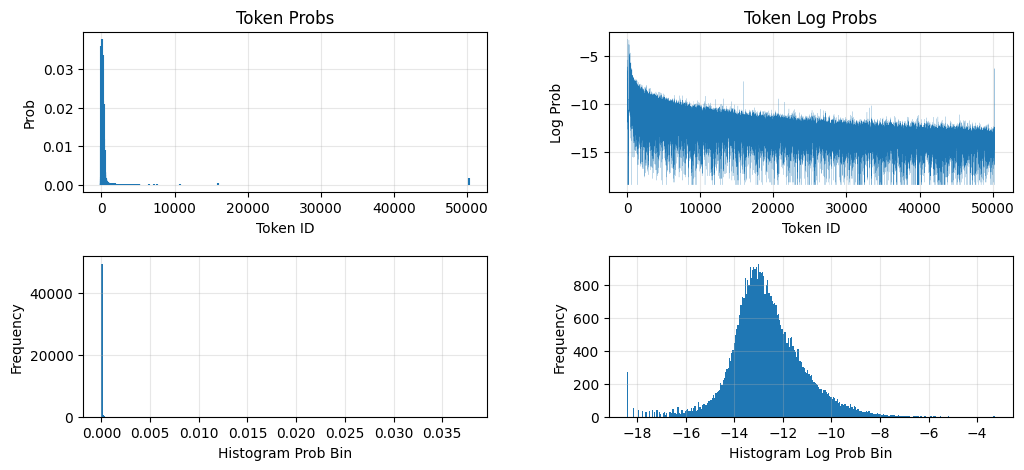

In [108]:
fig, axes = plt.subplots(2, 2, figsize=(12, 5))
axes = axes.flatten()
ax1, ax2, ax3, ax4 = axes[0], axes[1], axes[2], axes[3]

x = frac.cpu().numpy()
ax1.vlines(x=range(D_VOCAB),ymin=0, ymax=x)
ax1.set_title('Token Probs')
ax1.set_xlabel('Token ID')
ax1.set_ylabel('Prob')
ax1.grid(True, alpha=0.3)

x = log_frac.cpu().numpy()
ax2.plot(x, linewidth=0.1)
ax2.set_title('Token Log Probs')
ax2.set_xlabel('Token ID')
ax2.set_ylabel('Log Prob')
ax2.grid(True, alpha=0.3)

x = frac.cpu().numpy()
x.sort()
ax3.hist(x[::-1], bins=300)
ax3.set_xlabel('Histogram Prob Bin')
ax3.set_ylabel('Frequency')
ax3.grid(True, alpha=0.3)

x = log_frac.cpu().numpy()
x.sort()
ax4.hist(x[::-1], bins=300)
ax4.set_xlabel('Histogram Log Prob Bin')
ax4.set_ylabel('Frequency')
ax4.grid(True, alpha=0.3)

plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

In [194]:
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
text = " the"
tokens = tokenizer.encode(text)
print(f"Token IDs: {tokens}")
decoded_text = tokenizer.decode(tokens)
print(f"Decoded text: '{decoded_text}'")
print(frac[262])

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Token IDs: [262]
Decoded text: ' the'
tensor(0.0336, device='cuda:0')


In [245]:
frac[534]

tensor(0.0032, device='cuda:0')

In [242]:
vals, idxs = frac.topk(k=200)
idxs

tensor([   13,    11,   262,   198,   290,   284,   286,   257,   287,    12,
          447,   318,   329,   326,   247,   345,   351,   319,   314,   340,
           82,   389,   355,   307,    25,   357,   373,   379,   423,   393,
          534,   422,   428,   416,   383,   481,   460,   281,   407,   356,
          338,     8,   468,   250,   251,   477,   464,   475,   564,   511,
          517,   484, 50256,    30,   530,   546,   674,   616,   465,   339,
          503,   510,     0,   543,    83,    14,   508,   523,   635,   640,
          587,   588,   618,   466,   644,   550,   632,   611,   547,   584,
          612,   366,    40,   617,   607,   606,   561,   655,   649,   656,
          651,   531,   621,   502,   663,   661,   532,    26,   784,     1,
          717,   597,   625,   703,   787,   691,   770,   645,   278,   317,
          749,   470,   670,   743,   734,   880,   775,   777,   514,   673,
          352,    91,   554,   779,   845,   812,   867,   835, 

In [127]:
tokens = tokenizer.encode([i.item() for i in idxs])
decoded_text = tokenizer.decode(tokens)
print(f"Decoded text: '{decoded_text}'")
print(vals)

Decoded text: '., the
'
tensor([0.0378, 0.0360, 0.0336, 0.0217], device='cuda:0')


In [221]:
model_path = 'Nov16Full/torch/step=0/model.pt'
model = load_model(model_path)

0.030249784 3.21875 -3.71875


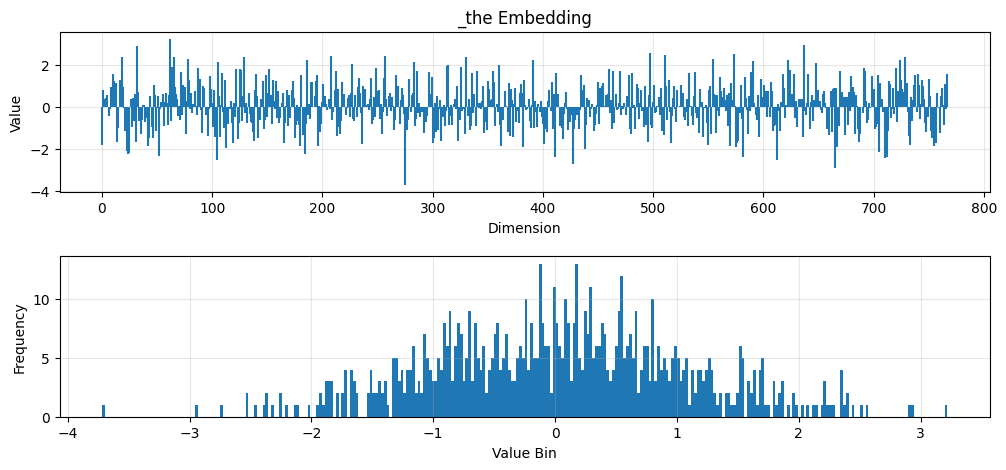

In [138]:
x = model.embed.weight[262].detach().cpu().float().numpy()
print(x.mean(), x.max(), x.min())
fig, axes = plt.subplots(2, 1, figsize=(12, 5))
axes = axes.flatten()
ax1, ax2 = axes[0], axes[1]

ax1.vlines(x=range(768),ymin=0, ymax=x)
ax1.set_title('_the Embedding')
ax1.set_xlabel('Dimension')
ax1.set_ylabel('Value')
ax1.grid(True, alpha=0.3)

ax2.hist(x, bins=300)
#ax2.set_title('_the Embedding Histogram')
ax2.set_xlabel('Value Bin')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.3)

plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

-0.0073198685 3.9375 -4.21875


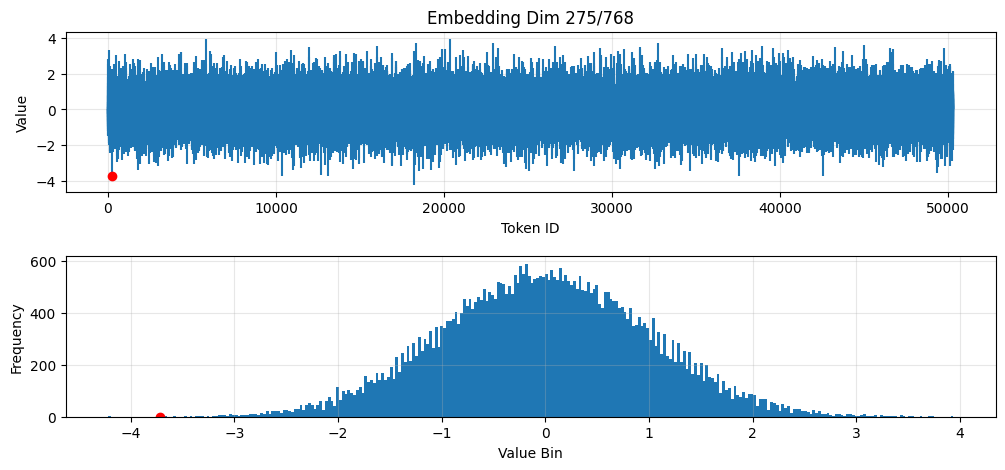

In [152]:
x = model.embed.weight[:, 275].detach().cpu().float().numpy()
print(x.mean(), x.max(), x.min())
fig, axes = plt.subplots(2, 1, figsize=(12, 5))
axes = axes.flatten()
ax1, ax2 = axes[0], axes[1]

ax1.vlines(x=range(50304),ymin=0, ymax=x)
ax1.plot([262], x[262], 'o', color = 'red' ,label='_the')
ax1.set_title('Embedding Dim 275/768')
ax1.set_xlabel('Token ID')
ax1.set_ylabel('Value')
ax1.grid(True, alpha=0.3)

ax2.hist(x, bins=300)
ax2.plot(x[262], [0], 'o', color = 'red' ,label='_the')
#ax2.set_title('_the Embedding Histogram')
ax2.set_xlabel('Value Bin')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.3)

plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

In [64]:
r0=[]
r1=[]
r2=[]

val_steps = val_accum_steps * args.val_tokens // args.val_batch_size
val_loader = distributed_data_generator(args.val_files, args.val_batch_size, -1, grad_accum_steps=val_accum_steps, align_to_bos=False)
val_loss = 0
ws_short, ws_long= 1, 3
outs = []
for _ in range(10):
  with torch.no_grad():
      inputs, targets, cum_seqlens = next(val_loader)
      x = model.fastforward(inputs, targets, cum_seqlens, ws_short, ws_long)
      outs.append(x)
outs = np.concat(outs, axis=1)

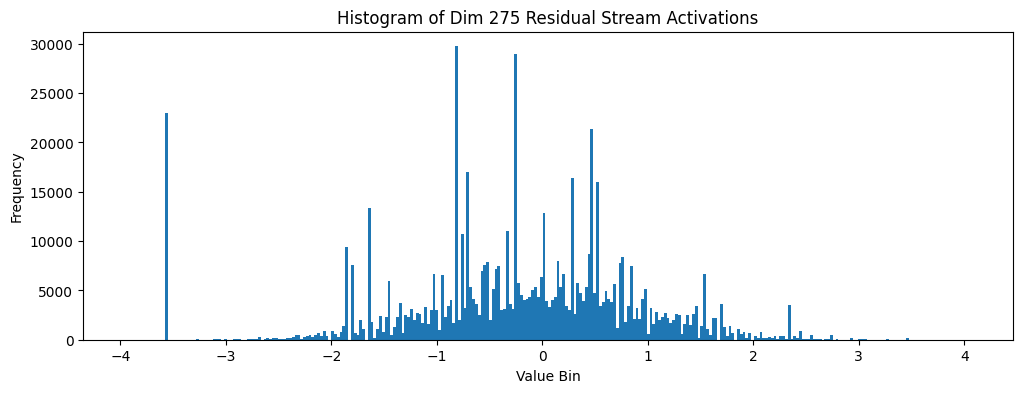

In [65]:
plt.figure(figsize=(12,4),dpi=100)
plt.hist(outs[0], bins=300)
plt.title('Histogram of Dim 275 Residual Stream Activations')
plt.xlabel('Value Bin')
plt.ylabel('Frequency')
plt.show()

In [226]:
r0=[]
r1=[]
r2=[]

val_steps = val_accum_steps * args.val_tokens // args.val_batch_size
val_loader = distributed_data_generator(args.val_files, args.val_batch_size, -1, grad_accum_steps=val_accum_steps, align_to_bos=False)
val_loss = 0
ws_short, ws_long= 1, 3
outs = []
for _ in range(10):
  with torch.no_grad():
      inputs, targets, cum_seqlens = next(val_loader)
      x = model.fastforward(inputs, targets, cum_seqlens, ws_short, ws_long, active_dim=360)
      outs.append(x)
outs = np.concat(outs, axis=1)

In [232]:
model.embed.weight[262,573]

tensor(2.5156, device='cuda:0', dtype=torch.bfloat16,
       grad_fn=<SelectBackward0>)

In [230]:
model.embed.weight[262,360]

tensor(1.9844, device='cuda:0', dtype=torch.bfloat16,
       grad_fn=<SelectBackward0>)

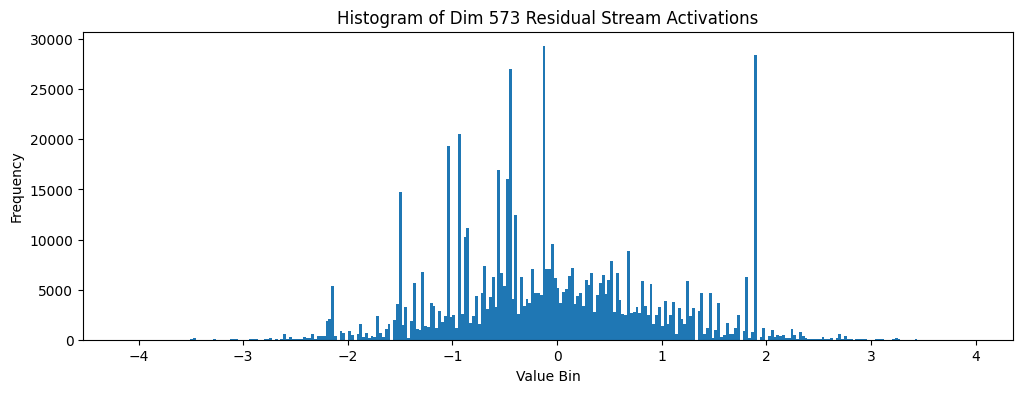

In [227]:
plt.figure(figsize=(12,4),dpi=100)
plt.hist(outs[0], bins=300)
plt.title('Histogram of Dim 573 Residual Stream Activations')
plt.xlabel('Value Bin')
plt.ylabel('Frequency')
plt.show()

In [224]:
outs.mean()

np.float32(0.28643325)

In [87]:
r0=[]
r1=[]
r2=[]

val_steps = val_accum_steps * args.val_tokens // args.val_batch_size
val_loader = distributed_data_generator(args.val_files, args.val_batch_size, -1, grad_accum_steps=val_accum_steps, align_to_bos=False)
val_loss = 0
ws_short, ws_long= 1, 3
outs = []
#for _ in range(10):
with torch.no_grad():
    inputs, targets, cum_seqlens = next(val_loader)
    x = model.fastforwardmean(inputs, targets, cum_seqlens, ws_short, ws_long)
    #outs.append(x)
#outs = np.concat(outs, axis=1)
x.shape

(768,)

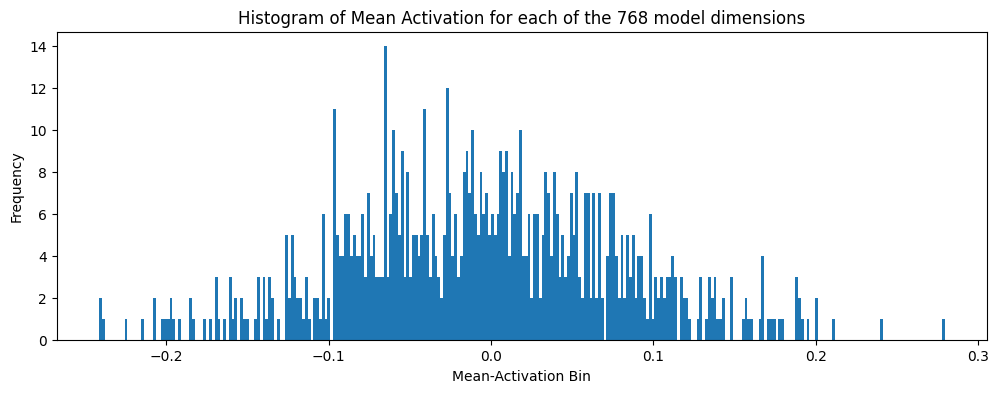

In [90]:
plt.figure(figsize=(12,4),dpi=100)
plt.hist(x, bins=300)
plt.title('Histogram of Mean Activation for each of the 768 model dimensions')
plt.xlabel('Mean-Activation Bin')
plt.ylabel('Frequency')
plt.show()

In [103]:
head_data = []
for i in range(2):

  model_path = f'Nov16Full/torch/step={i}/model.pt'
  model = load_model(model_path)
  x = model.lm_head.weight[:,275].detach().cpu().float().numpy()
  head_data.append(x)

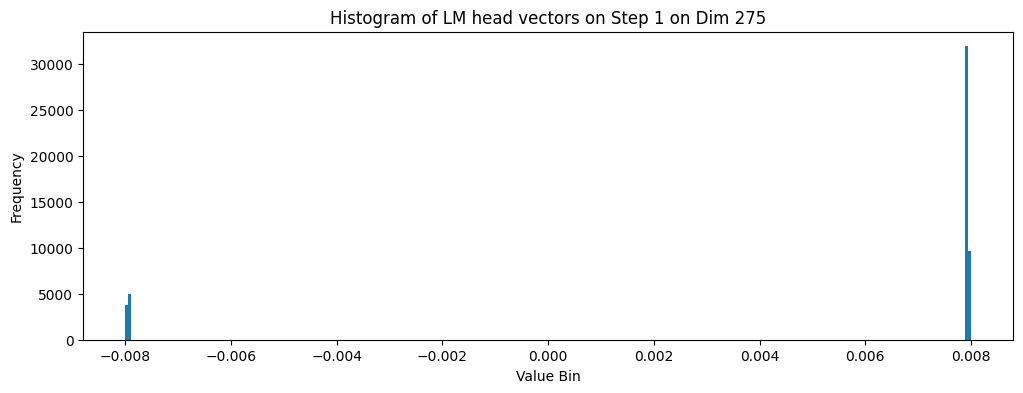

In [111]:
plt.figure(figsize=(12,4),dpi=100)
plt.hist(head_data[-1], bins=300)
plt.title('Histogram of LM head vectors on Step 1 on Dim 275')
plt.xlabel('Value Bin')
plt.ylabel('Frequency')
plt.show()

In [104]:
model.lm_head.weight[:,275].mean()

tensor(0.0052, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MeanBackward0>)

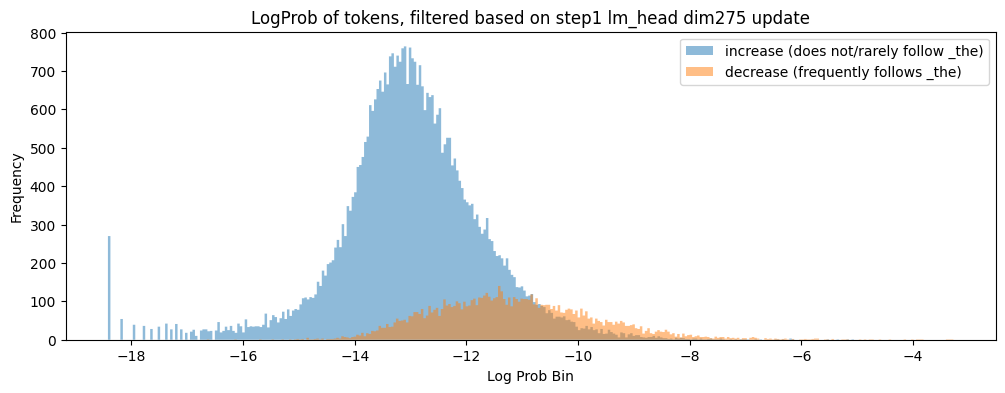

In [130]:
# for the tokens that decreased, show their frequency
weights = model.lm_head.weight[:D_VOCAB,275].detach().cpu().float().numpy()
freq = log_frac.cpu().float().numpy()
decrease = freq[weights<0]
increase = freq[weights>0]

plt.figure(figsize=(12,4),dpi=100)
plt.hist(increase, bins=300, alpha=0.5, label='increase (does not/rarely follow _the)', histtype='stepfilled')
plt.hist(decrease, bins=300, alpha=0.5, label='decrease (frequently follows _the)', histtype='stepfilled')

plt.title('LogProb of tokens, filtered based on step1 lm_head dim275 update')
plt.xlabel('Log Prob Bin')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [127]:
data = model.lm_head.weight[:D_VOCAB,275]*frac
print("Weighted mean of lm_head on step 1")
data.sum()

Weighted mean of lm_head on step 1


tensor(-0.0035, device='cuda:0', grad_fn=<SumBackward0>)

Weighted mean of lm_head on step 1


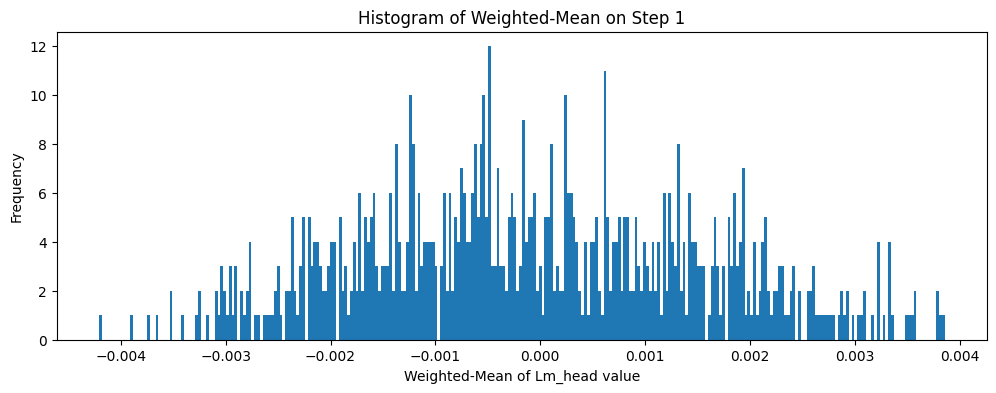

In [137]:
data = model.lm_head.weight[:D_VOCAB]*frac.unsqueeze(-1)
print("Weighted mean of lm_head on step 1")
x = data.sum(dim=0).detach().cpu().float().numpy()
plt.figure(figsize=(12,4),dpi=100)
plt.hist(x, bins=300)
plt.title('Histogram of Weighted-Mean on Step 1')
plt.xlabel('Weighted-Mean of Lm_head value')
plt.ylabel('Frequency')
plt.show()

In [138]:
# on step 2, how much are MLP out neurons pushing in this direction.
model_path = f'Nov16Full/torch/step=2/model.pt'
model = load_model(model_path)

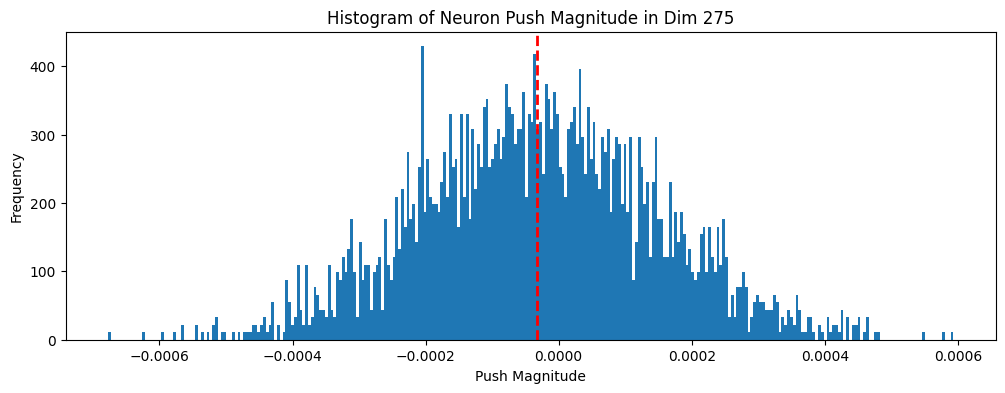

In [149]:
vals = []
for b in range(1,12):
  x = model.blocks[1].mlp.c_proj[275].detach()
  vals.append(x)
vals = torch.concat(vals).cpu().float().numpy()

plt.figure(figsize=(12,4),dpi=100)
plt.hist(vals, bins=300)
plt.title('Histogram of Neuron Push Magnitude in Dim 275')
plt.xlabel('Push Magnitude')
plt.axvline(np.mean(vals), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(vals):.3f}')
plt.ylabel('Frequency')
plt.show()

In [158]:
# look at the activations now..
r0=[]
r1=[]
r2=[]

val_steps = val_accum_steps * args.val_tokens // args.val_batch_size
val_loader = distributed_data_generator(args.val_files, args.val_batch_size, -1, grad_accum_steps=val_accum_steps, align_to_bos=False)
val_loss = 0
ws_short, ws_long= 1, 3

model_path = f'Nov16Full/torch/step=1/model.pt'
model = load_model(model_path)
with torch.no_grad():
    inputs, targets, cum_seqlens = next(val_loader)
    out1 = model.fastforward(inputs, targets, cum_seqlens, ws_short, ws_long)

val_steps = val_accum_steps * args.val_tokens // args.val_batch_size
val_loader = distributed_data_generator(args.val_files, args.val_batch_size, -1, grad_accum_steps=val_accum_steps, align_to_bos=False)

model_path = f'Nov16Full/torch/step=2/model.pt'
model = load_model(model_path)
with torch.no_grad():
    inputs, targets, cum_seqlens = next(val_loader)
    out2 = model.fastforward(inputs, targets, cum_seqlens, ws_short, ws_long)

In [159]:
(out2[0]-out1[0]).mean()

np.float32(-0.122063965)

In [157]:
out2[0, 275], out1[0, 275]

(np.float32(-0.32617188), np.float32(-0.26367188))

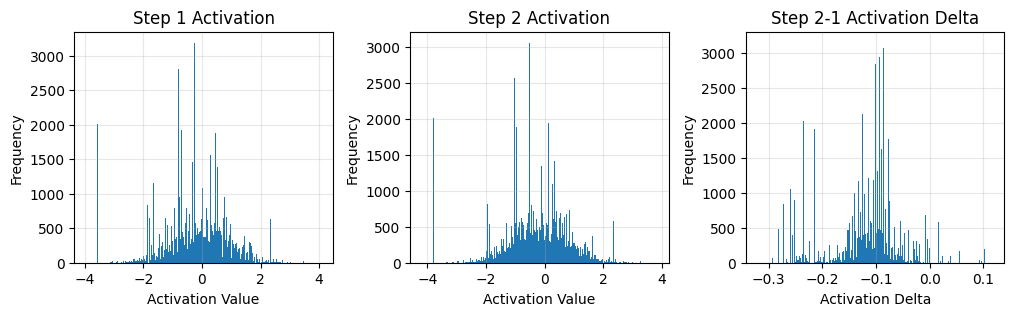

0.97711181640625

In [167]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
axes = axes.flatten()
ax1, ax2, ax3 = axes[0], axes[1], axes[2]
ax1.set_title('Step 1 Activation')
ax1.hist(out1[0], bins=300)
ax1.set_xlabel('Activation Value')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)

ax2.set_title('Step 2 Activation')
ax2.hist(out2[0], bins=300)
ax2.set_xlabel('Activation Value')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.3)

ax3.set_title('Step 2-1 Activation Delta')
ax3.hist(out2[0]-out1[0], bins=300)
ax3.set_xlabel('Activation Delta')
ax3.set_ylabel('Frequency')
ax3.grid(True, alpha=0.3)

plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

diff = out2[0]-out1[0]
diff[diff<0].shape[0]/diff.shape[0]

In [54]:
all_data = []
for step in range(600):
  if step%20==0:
    print(step)
  key = f'Nov16Full/numpy/weight/param=lm_head.weight/step={step}/data.npy'
  data = load_npy_from_s3(bucket_name, key)
  all_data.append(data[:, 275])

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580


In [55]:
all_data[-1].shape

(50304,)

In [56]:
all_data[-1].min(), all_data[-1].max()

(np.float32(-0.25195312), np.float32(0.609375))

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_title('Lm_Head Dim 275 - Step 0', fontsize=14, fontweight='bold')
ax.set_xlabel('Token ID')
ax.set_ylabel('Value')
ax.set_ylim(-.2, 0.2)

# Animation update function
def update(frame):
    ax.clear()
    ax.set_title(f'Lm_Head Dim 275 - Step {frame}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Token ID')
    ax.set_ylabel('Value')
    ax.set_ylim(-.3, 0.7)
    ax.vlines(x=range(50304),ymin=0, ymax=all_data[frame], linewidth=0.4)
    ax.grid(True, alpha=0.3)
    return ax,

# Create animation
anim = FuncAnimation(fig, update, frames=600, interval=50, repeat=True)

plt.close()  # Prevent static plot from showing

# Display animation in Jupyter
#HTML(anim.to_jshtml())

In [65]:
anim.save('lm_head_275_600s_thin.gif', writer='pillow', fps=30)

In [66]:
key = f'Nov16Full/numpy/weight/param=blocks.11.mlp.c_proj/step=600/data.npy'
data = load_npy_from_s3(bucket_name, key)
data.shape

(768, 3072)

In [69]:
np.argsort(data[275])

array([1269, 1452, 2895, ..., 1279,  846, 2461])

In [81]:
# take 1269, 1452, and 100
all_data= []
for step in range(600):
  if step%100==0:
    print(step)
  key = f'Nov16Full/numpy/weight/param=blocks.11.mlp.c_proj/step={step}/data.npy'
  data = load_npy_from_s3(bucket_name, key)
  all_data.append(data[:,[1269, 1452, 100]])

0
100
200
300
400
500


In [106]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Set up the figure

data = all_data[-1]
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
axes = axes.flatten()
ax1, ax2, ax3 = axes[0], axes[1], axes[2]
fig.suptitle(f'Layer 11 MLP Out Step 0')
ax1.set_title('Neuron 1269 push')
ax1.set_xlabel('Model Dim')
ax1.set_ylabel('Value')
ax1.set_ylim(-0.8, 0.25)
ax1.grid(True, alpha=0.3)

ax2.set_title('Neuron 1452 push')
ax2.set_xlabel('Model Dim')
ax2.set_ylim(-0.8, 0.25)
ax2.grid(True, alpha=0.3)

ax3.set_title('Neuron 100 push (baseline)')
ax3.set_xlabel('Model Dim')
ax3.set_ylim(-0.8, 0.25)
ax3.grid(True, alpha=0.3)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.subplots_adjust(hspace=0.4, wspace=0.3)
# Animation update function
def update(frame):
    data = all_data[frame]
    ax.clear()

    ax1.set_title('Neuron 1269 push')
    ax1.set_xlabel('Model Dim')
    ax1.set_ylabel('Value')
    ax1.set_ylim(-0.8, 0.25)
    ax1.grid(True, alpha=0.3)

    ax2.set_title('Neuron 1452 push')
    ax2.set_xlabel('Model Dim')
    ax2.set_ylim(-0.8, 0.25)
    ax2.grid(True, alpha=0.3)

    ax3.set_title('Neuron 100 push (baseline)')
    ax3.set_xlabel('Model Dim')
    ax3.set_ylim(-0.8, 0.25)
    ax3.grid(True, alpha=0.3)

    fig.suptitle(f'Layer 11 MLP Out Step {frame}')

    ax1.vlines(x=range(768),ymin=0, ymax=data[:,0], linewidth=1)
    ax2.vlines(x=range(768),ymin=0, ymax=data[:,1], linewidth=1)
    ax3.vlines(x=range(768),ymin=0, ymax=data[:,2], linewidth=1)
    return ax,

# Create animation
anim = FuncAnimation(fig, update, frames=600, interval=50, repeat=True)

plt.close()  # Prevent static plot from showing

# Display animation in Jupyter
#HTML(anim.to_jshtml())

In [107]:
anim.save('mlp_11_neuron_out.gif', writer='pillow', fps=30)

In [233]:
acts = []
for i in range(20):
  if i%50==0:
    print(i)
  model_path = f'Nov16Full/torch/step={i}/model.pt'
  model = load_model(model_path)
  r0=[]
  r1=[]
  r2=[]

  val_steps = val_accum_steps * args.val_tokens // args.val_batch_size
  val_loader = distributed_data_generator(args.val_files, args.val_batch_size, -1, grad_accum_steps=val_accum_steps, align_to_bos=False)
  val_loss = 0
  ws_short, ws_long= 1, 3
  with torch.no_grad():
      inputs, targets, cum_seqlens = next(val_loader)
      x = model.fastforward(inputs, targets, cum_seqlens, ws_short, ws_long, active_dim=360)
  acts.append(x)

0


In [122]:
acts[-1].shape

(1, 65536)

In [234]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


# Set up the figure
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.set_title('Normed Residual Activations Dim 275. Step 0')
ax.set_xlabel('Normed Activation')
ax.set_ylabel('Frequency')
ax.set_xlim(-30, 30)
ax.set_ylim(0, 1200)
ax.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 1])
#plt.subplots_adjust(hspace=0.4, wspace=0.3)
# Animation update function
def update(frame):
    if frame%50==0:
      print(frame)
    data = all_data[frame]
    ax.clear()

    ax.set_title(f'Normed Residual Activations Dim 275. Step {frame}')
    ax.set_xlabel('Normed Activation')
    ax.set_ylabel('Frequency')
    ax.set_xlim(-30, 30)
    ax.set_ylim(0, 1200)
    ax.grid(True, alpha=0.3)

    x = acts[frame][0]
    ax.hist(x, bins=300)
    ax.axvline(np.mean(x), color='red', linestyle='--', linewidth=2)
    ax.axvline(0, color='gray', linestyle='--', linewidth=2)
    return ax,

# Create animation
anim = FuncAnimation(fig, update, frames=20, interval=50, repeat=True)

plt.close()  # Prevent static plot from showing

# Display animation in Jupyter
HTML(anim.to_jshtml())

0
0


In [138]:
anim.save('activations_275.gif', writer='pillow', fps=30)

0
0
50
100
150
200
250
300
350
400
450
500
550


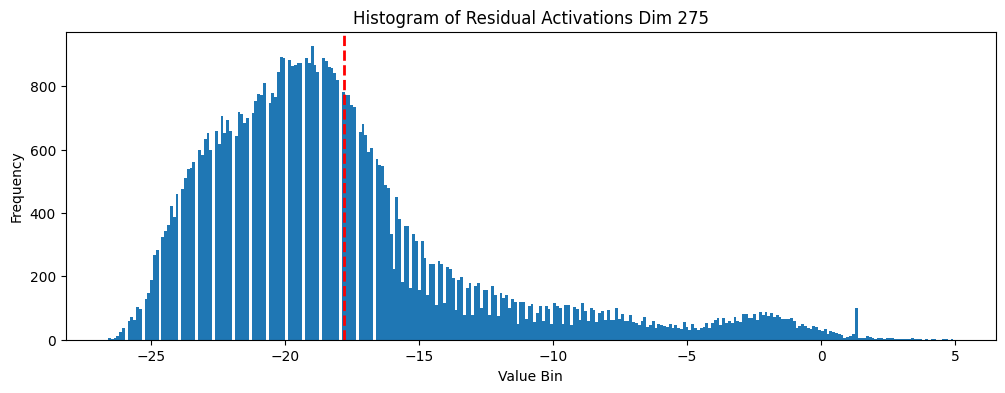

In [126]:
# do a histogram
x = acts[-1][0]
plt.figure(figsize=(12,4),dpi=100)
plt.hist(x, bins=300)
plt.title('Histogram of Residual Activations Dim 275')
plt.xlabel('Value Bin')
plt.axvline(np.mean(x), color='red', linestyle='--', linewidth=2)
plt.ylabel('Frequency')
plt.show()

In [179]:
# what is the bos token activating?
model_path = f'Nov16Full/torch/step=600/model.pt'
model = load_model(model_path)

In [180]:
val_loader = distributed_data_generator(args.val_files, args.val_batch_size, -1, grad_accum_steps=val_accum_steps, align_to_bos=False)
val_loss = 0
ws_short, ws_long= 1, 3
with torch.no_grad():
    inputs, targets, cum_seqlens = next(val_loader)
    pre, post = model.fastforwardall(inputs, targets, cum_seqlens, ws_short, ws_long)

pre.shape

(1000, 768)

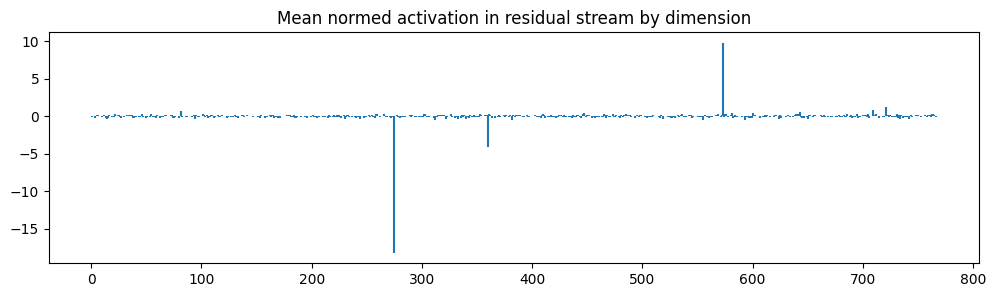

In [185]:
#when the model gets to step 600, are there any other activations?
plt.figure(figsize=(12,3), dpi=100)
plt.vlines(x=range(768),ymin=0, ymax=post.mean(axis=0))
plt.title('Mean normed activation in residual stream by dimension')
ax1.set_xlabel('Dimension')
ax1.set_ylabel('Value')
ax1.grid(True, alpha=0.3)

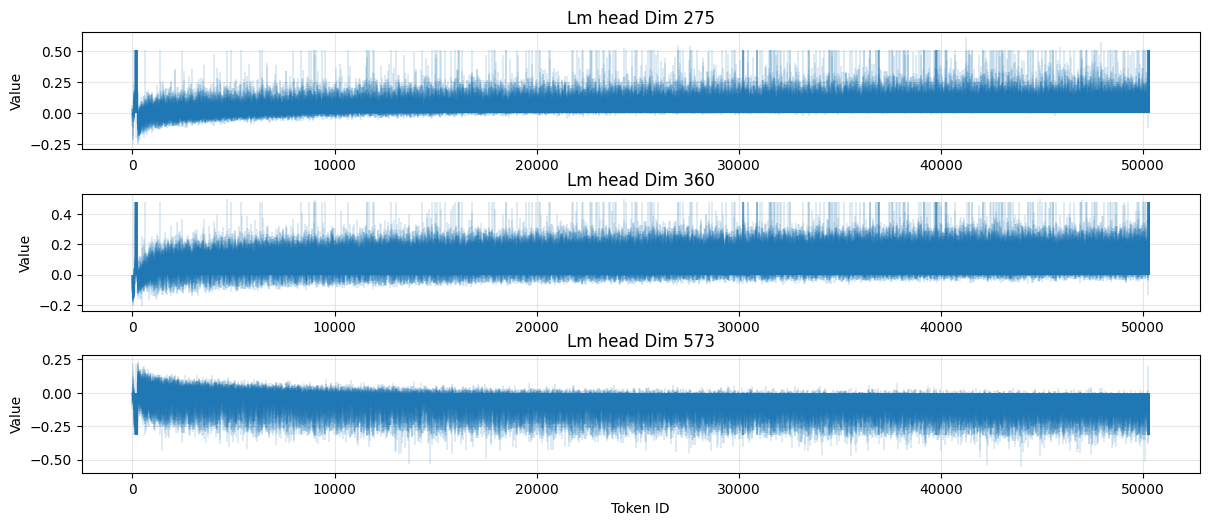

In [218]:
fig, axes = plt.subplots(3, 1, figsize=(12, 5))
axes = axes.flatten()
plt.tight_layout()
ax1, ax2, ax3 = axes[0], axes[1], axes[2]

ax1.vlines(x=range(50304),ymin=0, ymax=model.lm_head.weight[:,275].detach().cpu().float().numpy(), linewidth=0.2)
ax1.set_title('Lm head Dim 275')
#ax1.set_xlabel('Token ID')
ax1.set_ylabel('Value')
ax1.grid(True, alpha=0.3)

ax2.vlines(x=range(50304),ymin=0, ymax=model.lm_head.weight[:,360].detach().cpu().float().numpy(), linewidth=0.2)
ax2.set_title('Lm head Dim 360')
#ax2.set_xlabel('Token ID')
ax2.set_ylabel('Value')
ax2.grid(True, alpha=0.3)

ax3.vlines(x=range(50304),ymin=0, ymax=model.lm_head.weight[:,573].detach().cpu().float().numpy(), linewidth=0.2)
ax3.set_title('Lm head Dim 573')
ax3.set_xlabel('Token ID')
ax3.set_ylabel('Value')
ax3.grid(True, alpha=0.3)

#plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

In [56]:
r0=[]
r1=[]
r2=[]
# what is the bos token activation?
model_path = f'Nov16Full/torch/step=600/model.pt'
model = load_model(model_path)

val_loader = distributed_data_generator(args.val_files, args.val_batch_size, -1, grad_accum_steps=val_accum_steps, align_to_bos=False)
val_loss = 0
ws_short, ws_long= 1, 3
with torch.no_grad():
    inputs, targets, cum_seqlens = next(val_loader)
    pre, post = model.fastforwardall(inputs, targets, cum_seqlens, ws_short, ws_long)

post.shape

(1000, 768)

In [61]:
np.argmin(post[0])

np.int64(360)

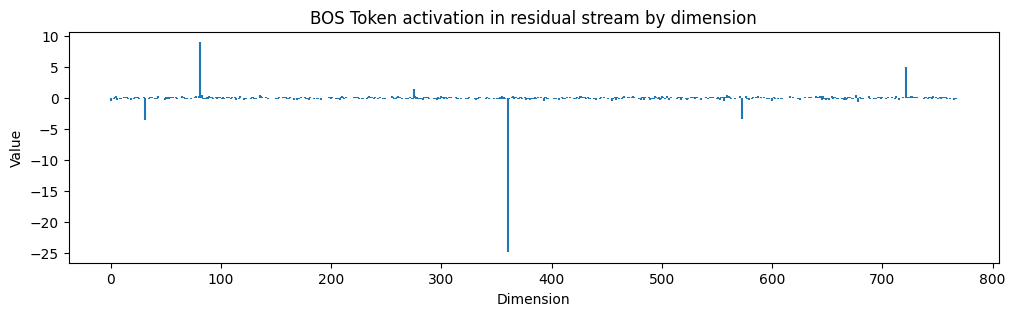

In [62]:
import matplotlib.pyplot as plt
#when the model gets to step 600, are there any other activations?
plt.figure(figsize=(12,3), dpi=100)
plt.vlines(x=range(768),ymin=0, ymax=post[0])
plt.title('BOS Token activation in residual stream by dimension')
plt.xlabel('Dimension')
plt.ylabel('Value')
#plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
#when the model gets to step 600, are there any other activations?
plt.figure(figsize=(12,3), dpi=100)
plt.vlines(x=range(768),ymin=0, ymax=post[0])
plt.title('BOS Token activation in residual stream by dimension')
plt.xlabel('Dimension')
plt.ylabel('Value')
#plt.grid(True, alpha=0.3)
plt.show()

In [68]:
frac.shape, log_frac.shape

(torch.Size([50257]), torch.Size([50257]))

In [78]:
import math
math.log(0.9), math.log(0.1)

(-0.10536051565782628, -2.3025850929940455)

In [83]:
loss = -torch.log(F.softmax(model.lm_head.weight[:,300].detach(),dim=0))[:50257]*frac
loss.sum()

tensor(10.8618, device='cuda:0')

In [85]:
F.softmax(-model.lm_head.weight[:,275].detach(),dim=0)

tensor([2.4080e-05, 2.2531e-05, 2.0981e-05,  ..., 1.2994e-05, 1.2994e-05,
        1.2994e-05], device='cuda:0', dtype=torch.bfloat16)

In [134]:
#we want the number to
data = []
data2 = []
data3 = []
for i in range(0, 300):
  loss = -torch.log(F.softmax(-i/10*model.lm_head.weight.detach(),dim=0))[:50257]*frac.unsqueeze(1)
  loss2 = -torch.log(F.softmax(i/10*model.lm_head.weight.detach(),dim=0))[:50257]*frac.unsqueeze(1)
  x=loss.sum(dim=0).cpu().numpy()
  x2=loss2.sum(dim=0).cpu().numpy()
  data.append(x[275].item())
  data2.append(x[360].item())
  data3.append(x2[573].item())

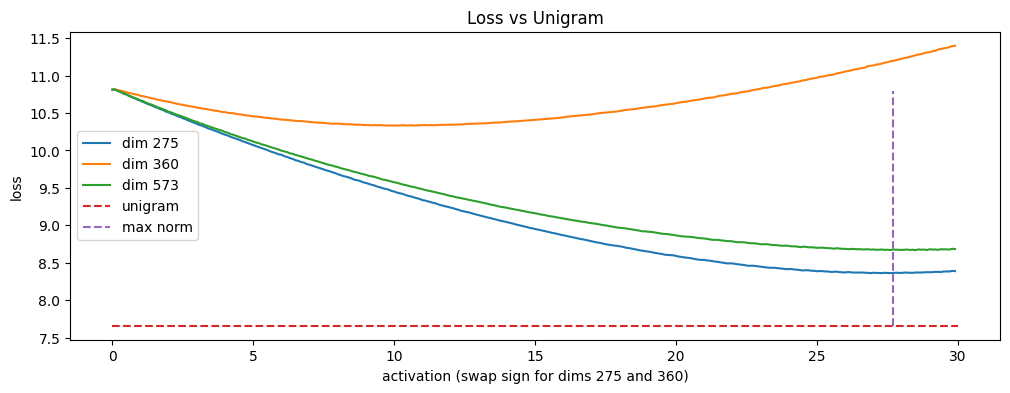

In [136]:
plt.figure(figsize=(12,4), dpi=100)
plt.title('Loss vs Unigram')
plt.plot([i/10 for i in range(300)],data, label='dim 275')
plt.plot([i/10 for i in range(300)],data2, label='dim 360')
plt.plot([i/10 for i in range(300)],data3, label='dim 573')
plt.plot([0,30], [7.66, 7.66], '--', label='unigram')
top = 768**0.5
plt.plot([top, top], [7.66, 10.8], '--', label='max norm')
plt.legend()
plt.ylabel('loss')
plt.xlabel('activation (swap sign for dims 275 and 360)')
plt.show()

In [214]:
frac
torch.save(frac, 'frac.pt')

15.672590255737305
7.754239082336426
7.742617607116699
7.738483905792236
7.736480712890625
7.735447406768799
7.734897136688232
7.734597682952881
7.734432697296143
7.734341621398926


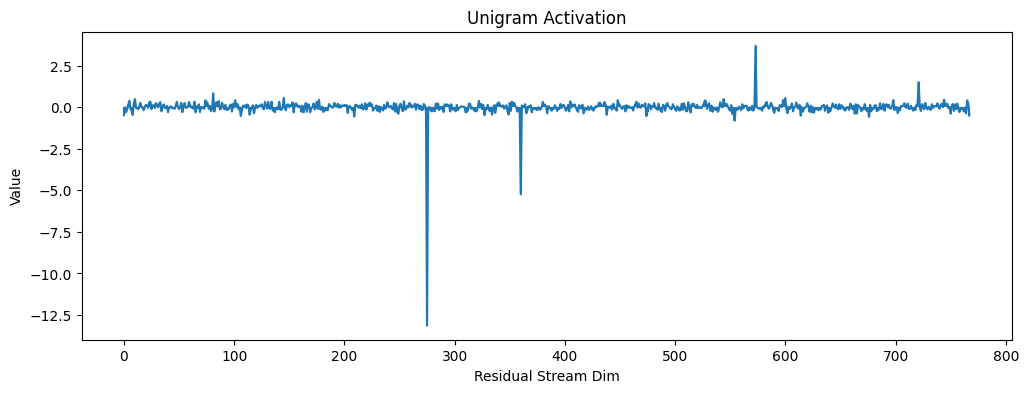

In [173]:
class UnigramModel(nn.Module):
  def __init__(self, d_model, d_vocab, fixed_head):
    super().__init__()
    self.w = nn.Parameter(torch.ones((1, d_model), device='cuda'))
    self.lm_head = fixed_head.clone()[:,:D_VOCAB]
  def forward(self, y):
    logits = (self.w @ self.lm_head).squeeze(0)
    log_probs = F.log_softmax(logits, dim=-1)
    loss = -(log_probs*y).sum()
    return loss
target = frac
unigram = UnigramModel(768, D_VOCAB, model.lm_head.weight.T.float().data)
optim = torch.optim.SGD(unigram.parameters(), lr=1)
for step in range(10000):
  loss = unigram(target)
  loss.backward()
  optim.step()
  optim.zero_grad()
  if step%1000==0:
    print(loss.item())

data = unigram.w.data.cpu().numpy()[0]
plt.figure(figsize=(12,4), dpi=100)
plt.title('Unigram Activation')
plt.plot(data)
plt.vlines(x=range(768),ymin=0, ymax=data)
plt.xlabel('Residual Stream Dim')
plt.ylabel('Value')
plt.show()

In [201]:
preds = F.softmax(-27*model.lm_head.weight.detach(),dim=0)
gap = preds[:,360]-preds[:,275]
vals, idxs = torch.topk(gap,k=10)
print('360 prefs:')
for idx in idxs:
  print(f"'{tokenizer.decode(idx)}'")

vals, idxs = torch.topk(-gap,k=10)
print('275 prefs')
for idx in idxs:
  print(f"'{tokenizer.decode(idx)}'")

gap = preds[:,275]-preds[:,573]
vals, idxs = torch.topk(-gap,k=10)
print('573 vs 275 prefs')
for idx in idxs:
  print(f"'{tokenizer.decode(idx)}'")
vals

vals, idxs = torch.topk(gap,k=10)
print('275 vs prefs 573')
for idx in idxs:
  print(f"'{tokenizer.decode(idx)}'")
vals

360 prefs:
'The'
'A'
'I'
'1'
'H'
'L'
'the'
'In'
'P'
'B'
275 prefs
','
' the'
' and'
' in'
' a'
' ('
'
'
' �'
' on'
' of'
573 vs 275 prefs
'ixtape'
'gorithm'
'adata'
'umbnails'
'initions'
'INGTON'
'ospels'
'helial'
' ..............'
'ウス'
275 vs prefs 573
','
' the'
' and'
' in'
'.'
' ('
' a'
'-'
'
'
' �'


tensor([0.0238, 0.0223, 0.0179, 0.0120, 0.0106, 0.0087, 0.0087, 0.0077, 0.0070,
        0.0060], device='cuda:0', dtype=torch.bfloat16)